<a href="https://colab.research.google.com/github/dannner66/data_science_NLP_beadando/blob/main/NLPprojektreDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Politikai hírek szentimentelemzése

## Bevezetés

A politikai hírek szentimentelemzése kulcsfontosságú a médiatartalmak érzelmi hangvételének megértésében, valamint a közbeszéd polarizációjának feltérképezésében.  
A projekt célja, hogy szövegbányászati és gépi tanulási módszerek alkalmazásával automatizált módon meghatározzuk politikai hírek érzelmi töltetét különböző forrásokból, és feltárjuk az időbeli változásokat, valamint a források közötti eltéréseket.

A munkafolyamat során a szöveges adatokat előfeldolgozzuk, jellemzőket (feature-öket) képzünk belőlük, majd klasszifikációs modelleket alkalmazunk az érzelmi kategóriák előrejelzésére.  
Az elemzés során figyelembe vesszük a tanórákon tárgyalt előfeldolgozási lépéseket (mint a zajszűrés, dimenziócsökkentés és regularizációs szempontok), valamint a klasszifikációs modellek teljesítménymutatóit (precision, recall, F1-score), az értékelést pedig a megfelelő bias-variance tradeoff figyelembevételével végezzük.

## Projekt céljai

A projekt során az alábbi fő célkitűzéseket tűztük ki:

- Politikai hírek érzelmi (szentiment) osztályozása különböző forrásokból származó adatok alapján.
- A hírek érzelmi hangvételének időbeli változásának vizsgálata.
- A különböző hírcsatornák közötti szentiment- és stílusbeli eltérések elemzése.
- Automatizált szövegosztályozási pipeline kialakítása a TF-IDF és embedding alapú reprezentációk összehasonlításával.

## Tartalomjegyzék

1. [Telepítések és importok](#Telepítések-és-importok)  
2. [Függvények és osztályok](#Függvények-és-osztályok)
2. [Bevezető és adatok bemutatása](#Bevezető-és-adatok-bemutatása)  
3. [Előfeldolgozás](#Előfeldolgozás)  
4. [Feature engineering](#Feature-engineering)  
5. [Modellek](#Modellek)  
6. [Diagnosztika](#Diagnosztika)  
7. [Aspektus- és időbeli elemzések](#Aspektus-és-időbeli-elemzések)
8. [Pipeline](#Pipeline)

# <a name="Telepítések-és-importok">1. Telepítés-és-importok</a>


## 1.1 Telepítések

A projekt során néhány külső könyvtárra van szükség a szövegfeldolgozáshoz, gépi tanulási modellek kezeléséhez, valamint az aspektus-alapú szentimentelemzéshez.  
Bár a notebookban egyes hosszabb futási idejű lépések eredményei (`.joblib`) előre el vannak mentve, az alábbi csomagok telepítése szükséges ahhoz, hogy az egész folyamat újrafuttatható legyen.

In [2]:
%%capture
!pip install keybert
!pip install nltk
!pip install sentence-transformers
!pip install transformers
!pip install torch
!pip install stanza

## 1.2 Könyvtárak importálása

A projekt során különböző könyvtárakat használunk a szövegfeldolgozáshoz, gépi tanulási modellek építéséhez, eredmények vizualizálásához és fájlok kezeléséhez.  
Az alábbiakban csoportosítva importáljuk a szükséges modulokat:  

- **Standard Python könyvtárak** (alapfunkciók: időkezelés, véletlenszámok, regex)
- **Adatkezelés** (NumPy, Pandas)
- **Vizualizáció** (Matplotlib, Seaborn)
- **Gépi tanulás** (Scikit-learn)
- **Deep Learning és Transformers** (Huggingface, PyTorch)
- **Szövegfeldolgozás** (NLTK, KeyBERT)
- **Segédmodulok** (Joblib, Pandas display optimalizálás)

In [3]:
# ===== Beépített csomagok =====
import datetime
import os
import sys
import random
import re
import time
import string
# ===== Harmadik féltől származó csomagok =====
import gdown
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import stanza
import torch
import torch.nn.functional as F
from tqdm import tqdm
from keybert import KeyBERT
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from scipy.special import softmax
from scipy.stats import ttest_ind
from sentence_transformers import SentenceTransformer
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, average_precision_score, classification_report,
    confusion_matrix, f1_score,ConfusionMatrixDisplay, precision_recall_curve, precision_score,
    recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding,
    pipeline, Trainer, TrainingArguments
)
import zipfile

# ===== Notebook beállítások =====
pd.options.display.max_columns = None
plt.rcParams["figure.figsize"] = (10, 5)
# Pipeline ábra megjelenítéséhez
set_config(display="diagram")

# <a name ="Függvények-és-osztályok">2. Függvények és osztályok</a>

In [5]:
#@title DriveDataDownloader and unziper
class DriveDataDownloader:
    def __init__(self, download_dir="."):
        self.download_dir = download_dir
        os.makedirs(download_dir, exist_ok=True)

    def download_and_unzip(self, file_id, output_name):
        output_path = os.path.join(self.download_dir, output_name)
        if not os.path.exists(output_path):
            gdown.download(id=file_id, output=output_path, quiet=False)
        else:
            print(f"{output_name} már létezik, nem töltöm le újra.")

        if output_name.endswith(".zip"):
            with zipfile.ZipFile(output_path, 'r') as zip_ref:
                zip_ref.extractall(self.download_dir)
                print(f"Kibontva: {output_name}")

In [6]:
#@title Szövegtisztító transformer (Pipeline-ba illeszthető)
class TextCleaner(BaseEstimator, TransformerMixin):
    """
    Szövegtisztító transformer:
    - kisbetűsítés
    - linkek eltávolítása
    - speciális karakterek törlése
    - felesleges szóközök csökkentése
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print("Szövegtisztítás elkezdve...")
        cleaned = []
        for i, text in enumerate(X):
            text = text.lower()
            text = re.sub(r"http\S+|www\.\S+", "", text)
            text = re.sub(r"[^a-záéíóöőúüűA-ZÁÉÍÓÖŐÚÜŰ\s]", " ", text)
            text = re.sub(r"\s+", " ", text).strip()
            cleaned.append(text)
            if i % max(1, len(X)//20) == 0 or i == len(X) - 1:
                print(f"\r Tisztítva: {i+1}/{len(X)}", end="")
        print("\n Szövegtisztítás kész.")
        return cleaned

In [7]:
#@title StanzaLemmatizer
class StanzaLemmatizer(BaseEstimator, TransformerMixin):
    """
    Magyar nyelvű lemmatizáló Stanza NLP-vel.
    Automatikusan letölti a modellt és kihagyja az üres szövegeket.
    """
    def __init__(self):
        import stanza
        stanza.download('hu', processors='tokenize,lemma', verbose=False)
        self.nlp = stanza.Pipeline(lang='hu', processors='tokenize,lemma', tokenize_no_ssplit=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_texts = []
        for i, text in enumerate(X):
            if not isinstance(text, str):
                cleaned_texts.append("")
                continue
            try:
                doc = self.nlp(text)
                lemmas = [word.lemma for sent in doc.sentences for word in sent.words]
                cleaned_texts.append(" ".join(lemmas))
            except Exception as e:
                print(f"Hiba a(z) {i}. szövegnél: {e}")
                cleaned_texts.append("")

            if i % 100 == 0:
                print(f"Lemmatizálva: {i}/{len(X)}")

        return pd.Series(cleaned_texts)

In [8]:
#@title Stopword szűrés
class StopwordRemover(BaseEstimator, TransformerMixin):
    """
    Magyar stopword kiszűrő transformer. Automatikusan letölti a 'stopwords' korpuszt.
    """
    def __init__(self):
        try:
            self.stopwords = set(stopwords.words("hungarian"))
        except LookupError:
            print("'stopwords' korpusz nem található. Letöltés...")
            nltk.download("stopwords")
            self.stopwords = set(stopwords.words("hungarian"))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = []
        for i, text in enumerate(X):
            if not isinstance(text, str):
                result.append("")
                continue
            words = text.split()
            filtered = [word for word in words if word not in self.stopwords and word.isalpha()]
            result.append(" ".join(filtered))
            if i % 100 == 0:
                print(f"Szűrve: {i}/{len(X)}")
        return pd.Series(result)

In [9]:
#@title SentimentAnalyzer
class SentimentAnalyzer:
    def __init__(self, model_name="cardiffnlp/twitter-xlm-roberta-base-sentiment"):
        print(f"Modell betöltése: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.eval()
    def predict(self, text):
        if not isinstance(text, str) or not text.strip():
            return {"negative": 0.0, "neutral": 1.0, "positive": 0.0}
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probs = softmax(logits, dim=1).numpy()[0]
        return dict(zip(["negative", "neutral", "positive"], probs))
    def predict_many(self, texts, batch_size=16, device=None):
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        encodings = self.tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        self.model.to(device)
        all_probs = []

        with torch.no_grad():
            for input_ids, attention_mask in loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                logits = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
                probs = F.softmax(logits, dim=1).cpu().numpy()  # ✅ PyTorch softmax
                all_probs.extend(probs)

        return np.array(all_probs)

In [10]:
#@title AspectSentimentAnalyzer
class AspectSentimentAnalyzer:
    """
    Aspektus-alapú sentiment pipeline:
    - kulcsszavakat keres KeyBERT-tel
    - szöveget mondatokra bont
    - csak kulcsszavas mondatokra becsli meg a sentimentet
    """
    def __init__(self, sentiment_analyzer, kw_model=None, top_n_keywords=5):
        """
        sentiment_analyzer: SentimentAnalyzer példány
        kw_model: KeyBERT példány (ha nincs megadva, automatikusan példányosítjuk)
        top_n_keywords: hány aspektuskulcsszót emeljen ki
        """
        self.sentiment_analyzer = sentiment_analyzer
        self.kw_model = kw_model or KeyBERT()
        self.top_n_keywords = top_n_keywords
    def analyze(self, text):
        """
        Egy szövegre visszaadja a kulcsszavakhoz tartozó sentiment értékeket.
        Visszatér: lista: [(kulcsszó, {'positive': ..., ...}), ...]
        """
        sentences = sent_tokenize(text)
        keywords = self.kw_model.extract_keywords(
            text,
            keyphrase_ngram_range=(1, 2),
            stop_words='english',
            top_n=self.top_n_keywords
        )
        keywords = [kw[0] for kw in keywords]
        result = []
        for kw in keywords:
            matched_sentences = [s for s in sentences if kw in s]
            if matched_sentences:
                sentiments = [
                    self.sentiment_analyzer.predict(s) for s in matched_sentences
                ]
                # Átlagoljuk a predikciókat
                avg_sentiment = {
                    k: sum(d[k] for d in sentiments) / len(sentiments)
                    for k in sentiments[0]
                }
                result.append((kw, avg_sentiment))
        return result

In [11]:
#@title patched_predict for ABSA
def _patched_predict(self, text):
        """
        Csak a dim=1-et használja a PyTorch softmax, így nem dob
        'unexpected keyword argument "dim"' hibát.
        """
        # tokenizálás truncationnel és paddal, hogy fix batch size legyen
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True
        )
        with torch.no_grad():
            logits = self.model(**inputs).logits       # (1, 3) tensor
            probs  = F.softmax(logits, dim=1)         # itt dim=1
            probs  = probs.cpu().numpy()[0]           # numpy tömbbé
        return dict(zip(["negative", "neutral", "positive"], probs))

In [12]:
#@title extract_aspektus_adatok_with_analyzer
def extract_aspektus_adatok_with_analyzer(
    combined_df: pd.DataFrame,
    analyzer: AspectSentimentAnalyzer,
    model_dir: str = "models"
) -> pd.DataFrame:
    """
    Előállítja (vagy betölti) az aspektus-adatokat az AspectSentimentAnalyzer segítségével.

    Parameters
    ----------
    combined_df : pd.DataFrame
        A bemeneti DF, amiben legalább 'text', 'label' és 'link' oszlopok vannak.
    analyzer : AspectSentimentAnalyzer
        A te aspektus‐sentiment analizáló osztályod példánya.
    model_dir : str
        Hova mentse a 'aspektus_adatok.joblib' fájlt.

    Returns
    -------
    pd.DataFrame
        Minden rekord: aspektus, pozitív/negatív/semleges átlag, label, link.
    """
    os.makedirs(model_dir, exist_ok=True)
    path = os.path.join(model_dir, "aspektus_adatok.joblib")
    # 1) Ha már létezik, töltsd be és térj vissza
    if os.path.isfile(path):
        return joblib.load(path)
    # 2) Egyébként gyűjtsd össze
    records = []
    for _, row in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Aspektus gyűjtés"):
        text  = row["text"]
        label = row["label"]
        link  = row["link"]
        # itt használjuk az AspectSentimentAnalyzer-t
        result = analyzer.analyze(text)
        # result: lista [(kulcsszó, {'positive':…, 'negative':…, 'neutral':…}), ...]
        for aspektus, scores in result:
            records.append({
                "aspektus":  aspektus,
                "pozitív":    scores.get("positive", 0.0),
                "negatív":    scores.get("negative", 0.0),
                "semleges":   scores.get("neutral",  0.0),
                "label":      label,
                "link":       link,
            })
    df_aspektus = pd.DataFrame.from_records(records)
    # 3) Mentsd el későbbre
    joblib.dump(df_aspektus, path)
    return df_aspektus

In [13]:
#@title load_datasets
def load_datasets(base_path="Adathalmaz"):
    """
    Betölti az adatfájlokat különböző forrásokból.
    Visszatér: neutral, telex, origo, combined_df (4 DataFrame)
    """
    neutral = pd.read_csv(f"{base_path}/neutral_news.csv")
    telex = pd.read_csv(f"{base_path}/telex_news.csv")
    origo = pd.read_csv(f"{base_path}/origo_news.csv")
    combined = pd.read_csv(f"{base_path}/combined.csv")
    return neutral, telex, origo, combined

In [14]:
#@title Teljes NLP pipeline építő
def build_full_pipeline():
    """Visszaad egy komplett szövegfeldolgozó és osztályozó pipeline-t."""
    # Szöveg előfeldolgozás (tisztítás, lemmatizálás, stopword szűrés)
    preprocessing_pipeline = Pipeline([
        ("cleaner", TextCleaner()),
        ("lemmatizer", StanzaLemmatizer()),
        ("stopword_remover", StopwordRemover())
    ])
    # TF-IDF reprezentáció
    vectorizer_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000))
    ])
    # Klasszikus gépi tanulási modell
    classifier = LogisticRegression(max_iter=1000)
    # Teljes pipeline összefűzése
    nlp_pipeline = Pipeline([
        ("preprocessing", preprocessing_pipeline),
        ("vectorizer", vectorizer_pipeline),
        ("classifier", classifier)
    ])
    return nlp_pipeline

In [15]:
#@title build, train and save pipeline
def build_and_train_pipeline(combined_df):
    """
    Csak a pipeline építése és tanítása:
      - Nem piszkálja a fájlrendszert,
      - Nem próbál pickle-elni.
    """
    pipeline      = build_full_pipeline()
    label_encoder = get_or_create_label_encoder(combined_df["label"])
    y             = label_encoder.transform(combined_df["label"])
    pipeline.fit(combined_df["text"], y)
    return pipeline, label_encoder

def save_pipeline(pipeline, label_encoder, model_dir="models"):
    """
    A Stanza‐lock eltávolítása után menti a pipeline-t és encoder-t.
    """
    os.makedirs(model_dir, exist_ok=True)
    p_path = os.path.join(model_dir, "nlp_pipeline.joblib")
    e_path = os.path.join(model_dir, "label_encoder.joblib")

    # 1) Stanza-lock eltávolítása
    try:
        lem = pipeline.named_steps["preprocessing"].named_steps["lemmatizer"]
        lem._saved_nlp = getattr(lem, "nlp", None)
        lem.nlp       = None
    except Exception:
        pass

    # 2) Mentés
    joblib.dump(pipeline,      p_path)
    joblib.dump(label_encoder, e_path)

    # 3) Betöltés és lock visszaállítása (opcionális, de javasolt ellenőrzésképp)
    pl2 = joblib.load(p_path)
    le2 = joblib.load(e_path)
    try:
        lem2 = pl2.named_steps["preprocessing"].named_steps["lemmatizer"]
        if hasattr(lem2, "_saved_nlp"):
            lem2.nlp = lem2._saved_nlp
            del lem2._saved_nlp
    except Exception:
        pass

    return pl2, le2

In [16]:
#@title Új szöveg osztályozás – load + restore + predict egy cellában {form}
def load_restore_and_predict(texts, model_dir="models"):
    """
    Betölti és restaurálja a teljes pipeline-t, majd lefuttatja rajta a predict-et.
    texts: List[str] – új szövegek
    """
    # 1) Betöltés
    p_path = os.path.join(model_dir, "nlp_pipeline.joblib")
    pipeline = joblib.load(p_path)

    # 2) Stanza-nlp visszaállítása
    try:
        lem = pipeline.named_steps["preprocessing"].named_steps["lemmatizer"]
        if hasattr(lem, "_saved_nlp"):
            lem.nlp = lem._saved_nlp
            del lem._saved_nlp
    except Exception:
        pass

    # 3) Predict
    preds = pipeline.predict(texts)
    return preds

In [17]:
#@title print_source_counts
def print_source_counts(df):
    """
    Kinyomtatja, hogy a megadott DataFrame-ben hány cikk tartozik az egyes forrásokhoz ('label' szerint).
    """
    if "label" not in df.columns:
        raise ValueError("A DataFrame nem tartalmaz 'label' oszlopot.")
    source_counts = df["label"].value_counts()
    print("Cikkek forrásonként:\n")
    print(source_counts)

In [18]:
#@title print_date_interval
def print_date_interval(df, date_column="date"):
    """
    Megadja az adatbázisban szereplő időbélyegek legkorábbi és legkésőbbi dátumát.

    Paraméterek:
        df: pandas DataFrame
        date_column: az oszlop neve, ahol az időbélyegek találhatók

    Működés:
        - átalakítja datetime típussá
        - kiszűri az érvénytelen (NaT) értékeket
        - kiírja az időintervallumot
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
    valid_dates = df[date_column].dropna()
    if valid_dates.empty:
        print("Nincsenek érvényes időbélyegek.")
        return
    min_d = valid_dates.min().date()
    max_d = valid_dates.max().date()
    print(f"Időintervallum: {min_d} – {max_d}")


In [19]:
#@title plot_source_distribution
def plot_source_distribution(df):
    """
    Kirajzolja a cikkek számát forrásonként egy oszlopdiagramon.

    Paraméter:
        df: pandas DataFrame, amely tartalmaz egy 'label' oszlopot.
    """
    if "label" not in df.columns:
        raise ValueError("A DataFrame nem tartalmaz 'label' oszlopot.")

    ax = df["label"].value_counts().plot(
        kind='bar',
        color=['skyblue', 'lightgreen', 'salmon']
    )
    plt.title("Cikkek száma forrásonként", fontsize=14)
    plt.xlabel("Forrás", fontsize=12)
    plt.ylabel("Cikkek száma", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [20]:
#@title filter_raw_text
def filter_raw_text(df,
                    text_column="text",
                    label_column="label",
                    min_length=100):
    """
    Eltávolítja a duplikált, hiányos vagy túl rövid szövegeket.
    """
    df = df.copy()
    df.drop_duplicates(subset=text_column, inplace=True)
    df.dropna(subset=[text_column, label_column], inplace=True)
    df = df[df[text_column].str.len() > min_length]
    return df

In [21]:
#@title load_or_create_column
def load_or_create_column(df, column_name, transformer, path):
    """
    Betölt vagy létrehoz egy új oszlopot transformer segítségével.

    df: DataFrame
    column_name: új oszlop neve (amit létrehozunk)
    transformer: osztálypéldány (pl. TextCleaner())
    path: joblib útvonal
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    try:
        print(f"{column_name} betöltve.")
        return joblib.load(path)
    except FileNotFoundError:
        print(f"{column_name} generálása transformerrel: {transformer.__class__.__name__} ...")
        transformed = transformer.transform(df["text"] if column_name == "clean_text" else df["clean_text"])
        joblib.dump(transformed, path)
        return transformed


In [22]:
#@title get_or_create_label_encoder
def get_or_create_label_encoder(labels,
                                encoder_path="models/label_encoder.joblib"):
    try:
        le = joblib.load(encoder_path)
        print("LabelEncoder betöltve.")
    except FileNotFoundError:
        print("LabelEncoder újraépítése...")
        le = LabelEncoder()
        le.fit(labels)
        os.makedirs("models", exist_ok=True)
        joblib.dump(le, encoder_path)
    return le


In [23]:
#@title encode_labels
def encode_labels(df,
                  column="label",
                  output_path="models/label_encoder.joblib"):
    from sklearn.preprocessing import LabelEncoder
    import joblib, os

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    try:
        encoder = joblib.load(output_path)
        print("LabelEncoder betöltve.")
    except FileNotFoundError:
        print("LabelEncoder újraépítése...")
        encoder = LabelEncoder()
        encoder.fit(df[column])
        joblib.dump(encoder, output_path)

    df["label_encoded"] = encoder.transform(df[column])
    return df, encoder

In [24]:
#@title get_or_create_tfidf
def get_or_create_tfidf(texts,
                        vectorizer_path="models/tfidf_vectorizer.joblib",
                        matrix_path="models/X_tfidf.joblib"):
    try:
        vectorizer = joblib.load(vectorizer_path)
        X = joblib.load(matrix_path)
        print("TF-IDF betöltve.")
    except FileNotFoundError:
        print("TF-IDF újraépítése...")
        vectorizer = TfidfVectorizer(max_features=5000)
        X = vectorizer.fit_transform(texts)
        os.makedirs("models", exist_ok=True)
        joblib.dump(vectorizer, vectorizer_path)
        joblib.dump(X, matrix_path)
    return X, vectorizer

In [25]:
#@title get_or_create_sbert
def get_or_create_sbert(
    texts,
    model_name="distiluse-base-multilingual-cased",
    output_path="models/sbert_embeddings.joblib"
):
    """
    SBERT embedding generálása vagy betöltése, biztonságos szöveg-előkészítéssel.
    """
    try:
        X = joblib.load(output_path)
        print("SBERT embedding betöltve.")
    except FileNotFoundError:
        print("SBERT újraépítése...")
        # Modell betöltése
        model = SentenceTransformer(model_name)
        # Szövegek tisztítása
        texts = pd.Series(texts).fillna("").astype(str).reset_index(drop=True).tolist()
        # Embeddingek előállítása
        X = model.encode(texts, show_progress_bar=True)
        # Mentés
        joblib.dump(X, output_path)
    return X



In [26]:
#@title evaluate_model
def evaluate_model(y_true, y_pred, labels=None, title=""):
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=labels,
                yticklabels=labels,
                cmap="YlGnBu")
    plt.title(f"{title} Konfúziós Mátrix")
    plt.xlabel("Előrejelzett")
    plt.ylabel("Valós")
    plt.tight_layout()
    plt.show()

# --- Kiértékelő függvény ---
def re_evaluate_model(name, y_true, y_pred):
    return {
        "Modell": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro")
    }

In [27]:
#@title train_and_evaluate_nb_tfidf
def train_and_evaluate_nb_tfidf(df,
                                label_column="label",
                                text_column="lemmatized_nostop"
                                ):
    """
    TF-IDF + Naive Bayes modell tanítása és kiértékelése.
    Nincs globális változó.
    """
    # TF-IDF reprezentáció betöltése vagy újragenerálása
    X_tfidf, _ = get_or_create_tfidf(df[text_column])
    # Label encoding
    label_encoder = get_or_create_label_encoder(df[label_column])
    y = label_encoder.transform(df[label_column])
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, stratify=y, random_state=42
    )
    # Naive Bayes modell
    model = MultinomialNB()
    model.fit(X_train, y_train)
    # Modell mentése
    joblib.dump(model, "models/nb_tfidf.joblib")
    # Előrejelzés és kiértékelés
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, label_encoder.classes_, "TF-IDF + Naive Bayes")
    return model, label_encoder, (X_train, X_test, y_train, y_test), y_pred


In [28]:
#@title train_and_evaluate_lr_tfidf
def train_and_evaluate_lr_tfidf(df,
                                text_column="lemmatized_nostop",
                                label_column="label"):
    """
    TF-IDF + LogisticRegression modell tanítása és kiértékelése.

    Parameters:
    - df: DataFrame, amely a szöveg- és címkeoszlopokat tartalmazza
    - text_column: szöveges oszlop neve
    - label_column: címkék oszlop neve

    Returns:
    - model: betanított LR modell
    - label_encoder: fitted LabelEncoder
    - (X_train, X_test, y_train, y_test): splitelt adatok
    - y_pred: előrejelzett címkék
    """
    print("TF-IDF újraépítése...")
    X_tfidf, vectorizer = get_or_create_tfidf(df[text_column].fillna(""))
    print("LabelEncoder újraépítése...")
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[label_column])
    print("Train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Logistic Regression tanítása...")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    print("Előrejelzés és kiértékelés:")
    y_pred = model.predict(X_test)
    evaluate_model(y_test,
                   y_pred, label_encoder.classes_,
                   "TF-IDF + Logistic Regression")
    # Mentés
    os.makedirs("models", exist_ok=True)
    joblib.dump(model, "models/lr_tfidf.joblib")
    joblib.dump(encoder, "models/lr_label_encoder.joblib")
    return model, encoder, (X_train, X_test, y_train, y_test), y_pred

In [29]:
#@title train_and_evaluate_lr_sbert
def train_and_evaluate_lr_sbert(df,
                                text_column="clean_text",
                                label_column="label"):
    """
    SBERT + LogisticRegression modell tanítása és kiértékelése.
    Parameters:
    - df: DataFrame, amely a szöveg- és címkeoszlopokat tartalmazza
    - text_column: szöveges oszlop neve (SBERT bemenet)
    - label_column: címkék oszlop neve
    Returns:
    - model: betanított LogisticRegression modell
    - label_encoder: fitted LabelEncoder
    - (X_train, X_test, y_train, y_test): splitelt adatok
    - y_pred: előrejelzett címkék
    """
    print("SBERT újraépítése...")
    X_sbert = get_or_create_sbert(df[text_column].fillna(""))
    print("LabelEncoder újraépítése...")
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[label_column])
    print("Train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_sbert, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Logistic Regression tanítása...")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    print("Előrejelzés és kiértékelés:")
    y_pred = model.predict(X_test)
    evaluate_model(y_test,
                   y_pred, label_encoder.classes_,
                   "SBERT + Logistic Regression modell")
    # Mentés
    os.makedirs("models", exist_ok=True)
    joblib.dump(model, "models/lr_sbert.joblib")
    joblib.dump(encoder, "models/lr_label_encoder.joblib")
    return model, encoder, (X_train, X_test, y_train, y_test), y_pred

In [30]:
#@title summarize_models
def summarize_models(y_test, predictions_dict, labels):
    """
    Összefoglalja a különböző modellek pontosságát és macro F1-score-ját.

    Parameters:
    - y_test: ground truth
    - predictions_dict: dict, pl. {"Naive Bayes": y_pred_nb, "LogReg TF-IDF": y_pred_lr, ...}
    - labels: label_encoder.classes_

    Returns:
    - results_df: pandas DataFrame
    """
    results = []
    for name, y_pred in predictions_dict.items():
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        results.append({
            "Modell": name,
            "Pontosság": round(acc, 4),
            "Macro F1-score": round(f1, 4)
        })
    return pd.DataFrame(results)

In [31]:
#@title ROC-PR görbék rajzolása
def evaluate_roc_pr_curves(y_true,
                           y_proba,
                           class_names,
                           title_prefix=""):
    """
    Kiértékeli és megrajzolja a ROC és PR görbéket többosztályos osztályozáshoz.

    Paraméterek:
    - y_true: ground truth (1D, egész értékek)
    - y_proba: osztályvalószínűségek (2D: [n_samples, n_classes])
    - class_names: címkék sorrendje
    - title_prefix: előtag a címhez

    Visszatér: ROC-AUC és PR-AUC értékek dict-je
    """
    y_true_bin = label_binarize(y_true,
                                classes=range(len(class_names)))
    roc_auc = roc_auc_score(y_true_bin,
                            y_proba,
                            average="macro",
                            multi_class="ovr")
    pr_auc = average_precision_score(y_true_bin,
                                     y_proba,
                                     average="macro")
    # ROC-görbék
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f"{class_name}")
    plt.title(f"{title_prefix} ROC-görbe")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    # PR-görbék
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, label=f"{class_name}")
    plt.title(f"{title_prefix} Precision–Recall görbe")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return {
        "ROC-AUC": round(roc_auc, 4),
        "PR-AUC": round(pr_auc, 4)
    }


In [32]:
#@title collect_roc_pr_results
def collect_roc_pr_results(results_dict):
    """
    Egyesíti több modell ROC- és PR-AUC értékeit táblázatba.
    Paraméter:
    - results_dict: {"modell neve": {"ROC-AUC": val, "PR-AUC": val}, ...}
    Visszatér: DataFrame
    """
    df = pd.DataFrame.from_dict(results_dict, orient="index")
    df.index.name = "Modell"
    return df.round(4)

In [33]:
#@title tune_logreg_tfidf
def tune_logreg_tfidf(X_train, y_train, scoring="f1_macro", cv=5):
    """
    LogisticRegression tuning TF-IDF-re GridSearchCV-vel.
    Paraméterek:
    - X_train: TF-IDF feature matrix (train)
    - y_train: címkék
    - scoring: értékelési metrika (default: f1_macro)
    - cv: cross-validation hajtások száma
    Visszatér:
    - best_estimator_: legjobb modell
    - best_params_: legjobb paraméterek
    - best_score_: legjobb CV pontszám
    """
    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "saga", "lbfgs"],
        "penalty": ["l2"]
    }

    grid = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_, grid.best_score_

In [34]:
#@title sentiment_pipeline_with_analyzer
def sentiment_pipeline_with_analyzer(df, sentiment_path="models/month_article_sentiments_all.joblib"):
    if os.path.exists(sentiment_path):
        combined_df = joblib.load(sentiment_path)
        print("Sentiment adatok betöltve:", sentiment_path)
    else:
        analyzer = SentimentAnalyzer()
        df = df.copy()
        sentiments = analyzer.predict_many(df["clean_text"].tolist())  # <-- új metódus használata
        df["negative"] = sentiments[:, 0]
        df["neutral"] = sentiments[:, 1]
        df["positive"] = sentiments[:, 2]
        df["sentiment_score"] = df["positive"] - df["negative"]

        df["date"] = pd.to_datetime(df["date"], utc=True, format="mixed", errors="coerce")
        df["day"] = df["date"].dt.date

        os.makedirs("models", exist_ok=True)
        joblib.dump(df, sentiment_path)
        print("Sentiment értékek elmentve:", sentiment_path)
        combined_df = df
    return combined_df



In [35]:
#@title Aspektus alapú szentiment
def plot_aspektus_sentiment_breakdown(
    aspektus: str,
    absa_df,
    aspektus_col: str = "aspektus",
    label_col:    str = "label",
    sentiment_cols = ("pozitív", "negatív", "semleges")
):
    """
    Átlagos 'pozitív'/'negatív'/'semleges' értékeket mutatja meg
    minden label-en ('telex','origo','neutral') az adott aspektusra.
    """
    # 1) Szűrés a kiválasztott aspektra
    df_as = absa_df[absa_df[aspektus_col] == aspektus]
    if df_as.empty:
        raise ValueError(f"Nincs '{aspektus}' aspektus a DataFrame-ben!")

    # 2) Átlagok label × sentiment oszlopokra
    stats = df_as.groupby(label_col)[list(sentiment_cols)].mean().reset_index()

    # 3) Csoportosított oszlopdiagram készítése
    labels     = stats[label_col].tolist()
    x          = np.arange(len(labels))
    k          = len(sentiment_cols)
    width      = 0.8 / k

    fig, ax = plt.subplots(figsize=(8, 4))
    for i, col in enumerate(sentiment_cols):
        offset = (i - (k-1)/2) * width
        ax.bar(x + offset, stats[col], width, label=col)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Átlagos érték")
    ax.set_title(f"Átlagos sentiment bontás az '{aspektus}' aspektushoz")
    ax.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

In [36]:
#@title Top 3 szó vizualizációja egy új mondatra {form}
def plot_top_features_for_text(pipeline, label_encoder, text, top_n=3):
    vect = pipeline.named_steps["vectorizer"].named_steps["tfidf"]
    clf  = pipeline.named_steps["classifier"]

    # 1) vektorizálás
    X = vect.transform([text])           # sparse 1×V
    coef = clf.coef_[np.argmax(clf.predict_proba(X)[0])]

    # 2) csak a nem‐nulla tfidf-értékek indexei
    nz = X.nonzero()[1]                  # ezek a szó‐indexek
    contrib = X.toarray()[0, nz] * coef[nz]

    # 3) ebből a top_n
    if len(nz) < top_n:
        top_n = len(nz)
    rel_idx = np.argsort(contrib)[-top_n:]
    idx = nz[rel_idx]

    feat_names = vect.get_feature_names_out()
    top_feats = feat_names[idx]
    top_vals  = contrib[rel_idx]

    # 4) ábra
    fig, ax = plt.subplots(figsize=(6,3))
    ax.barh(top_feats, top_vals)
    pred_lab = label_encoder.inverse_transform([np.argmax(clf.predict_proba(X)[0])])[0]
    ax.set_title(f"Top {top_n} szó a '{pred_lab}' besoroláshoz")
    ax.set_xlabel("Hozzájárulás a döntéshez")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


# <a name = "Bevezető-és-adatok-bemutatása">3. Bevezető és adatok bemutatása</a>




Ebben a szekcióban áttekintjük:
- **Adatforrások**: Origo (politikai és semleges cikkek), Telex (független hírek)  
- **Cikkek száma** és **forrásonkénti eloszlás**  
- **Időintervallum** (legkorábbi és legújabb dátum)  
- Egy **minta** (head) a `combined_df`-ből

## 3.1 Adatok forrása és letöltése

Az elemzéshez használt adathalmaz különböző hírcsatornák politikai témájú cikkeit tartalmazza.  
Az adatok négy CSV-fájlba vannak rendezve, amelyek külön tartalmazzák a semleges, baloldali és jobboldali beállítottságú források cikkeit, valamint egy teljes összevont változatot is.

A szükséges adatokat és előre elkészített modelleket a `gdown` könyvtár segítségével töltjük le Google Drive-ról.  
Az alábbi fájlok érhetők el:

- **Adathalmaz.zip**: tartalmazza a teljes szöveges adatbázist (cikkek szövege és metaadatai).
- **Models.zip**: tartalmazza az előre legenerált pipeline-okat és embeddingeket (`.joblib` fájlokban), hogy gyorsítsuk a projekt reprodukcióját.

In [ ]:
# Példányosítás és fájlok letöltése
downloader = DriveDataDownloader()
downloader\
.download_and_unzip("1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op", "Adathalmaz.zip")
# downloader\
# .download_and_unzip("1SFAvhspMrCG71Gf03xLISla_7PD97VjF", "Models.zip")

Downloading...
From: https://drive.google.com/uc?id=1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op
To: /content/Adathalmaz.zip
100%|██████████| 5.94M/5.94M [00:00<00:00, 74.1MB/s]


Kibontva: Adathalmaz.zip


## 3.2 Adatok előkészítése

A letöltött ZIP-fájlok kibontása után az adathalmaz külön forrásokra bontva érhető el:

- **neutral.csv**: semleges hírek gyűjteménye,
- **origo.csv**: jobboldali hírek,
- **telex.csv**: baloldali hírek,
- **combined_df.csv**: az összes forrás egyesítve.

A további elemzések az összevont `combined_df` adattáblán történnek.

In [ ]:
# 2.2 Adatok betöltése
neutral, telex, origo, combined_df = load_datasets()

## 3.3 Forrásonkénti eloszlás vizsgálata

A következő lépésben megvizsgáljuk, hogy a három fő forrásból (neutral, origo, telex) hány cikk található az adathalmazban.  
A források közötti eloszlás elemzése kulcsfontosságú, mivel az osztályok egyensúlya közvetlen hatással van a klasszifikációs modellek teljesítményére.

In [ ]:
# Forrásonkénti cikkek száma
print_source_counts(combined_df)

Cikkek forrásonként:

label
neutral    934
telex      691
origo      679
Name: count, dtype: int64


Az adatok alapján látható, hogy a semleges cikkek száma dominál, míg a két politikai forrásból hasonló mennyiségű adat érkezett.

## 3.4 Időintervallum elemzése

Az adathalmazban szereplő cikkek időbélyegzőit is megvizsgáljuk, hogy feltérképezzük az adatgyűjtés időbeli lefedettségét.  
A dátumok konvertálását követően kiszűrjük az esetleges hibás vagy hiányzó időbélyegzőket.  
Az érvényes adatok alapján meghatározzuk az adathalmaz időbeli intervallumát, amely a további időalapú szentimentelemzések alapját képezi.

In [ ]:
# Dátumkonverzió és érvénytelenek kiszűrése
print_date_interval(combined_df)

Időintervallum: 2025-03-19 – 2025-04-19


A cikkek az alábbi időintervallumból származnak:
**2025. március 19 – április 19**.
Ez a periódus az aspektus-időbeli elemzések alapját képezi.


## 3.5 Cikkek forrásonkénti megoszlása – grafikon

Az alábbi diagram a három hírcsatornából származó cikkek számát szemlélteti.  
Ez az egyszerű statisztikai eloszlás segít felmérni az adatbázis kiegyensúlyozottságát, ami befolyásolja a gépi tanulási modellek tanulási teljesítményét és a bias-variance arányt.

A grafikonon megfigyelhető, hogy a semleges cikkek száma a legnagyobb, míg a politikai oldalak cikkei kisebb, de közel azonos mennyiségben vannak jelen.

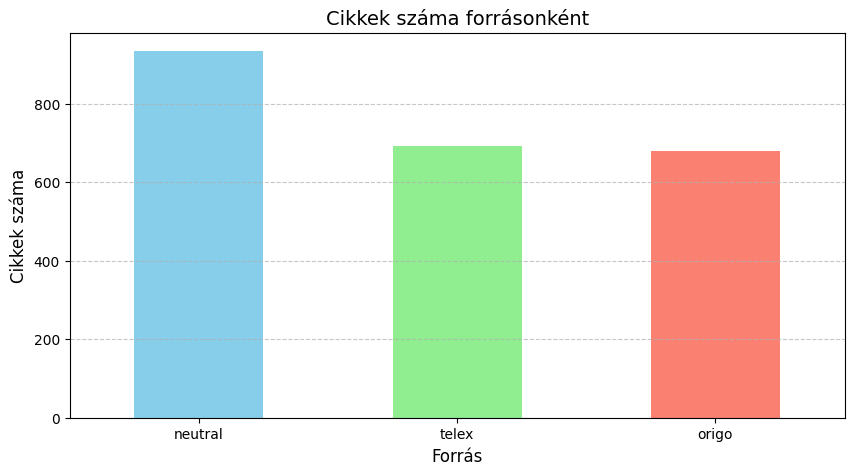

In [ ]:
plot_source_distribution(combined_df)

# <a name="Előfeldolgozás">4. Előfeldolgozás</a>



A nyers szövegek előkészítése elengedhetetlen a gépi tanulási pipeline-hoz.  
A következő lépések egymásra épülve biztosítják az adat tisztaságát és értelmezhetőségét:
- Duplikált, hibás vagy túl rövid szövegek eltávolítása  
- Szövegtisztítás (kisbetűsítés, linkek, speciális karakterek törlése)  
- Lemmatizálás  
- Stopword szűrés

## 4.1 Alapvető szövegtisztítás

Első lépésként eltávolítjuk a duplikált cikkeket, a hiányos bejegyzéseket, valamint kiszűrjük azokat a szövegeket, amelyek túl rövidek (és így nem hordoznak elég információt).  
Ezt követően egy egyszerű tisztítási függvényt alkalmazunk, amely a következő lépéseket hajtja végre:

- Kisbetűsítés a szöveg egységesítése érdekében.
- Linkek eltávolítása, amelyek irrelevánsak a szentimentelemzés szempontjából.
- Nem betű karakterek eltávolítása (pl. számok, szimbólumok).
- Többszörös szóközök egyszerűsítése.

A tisztított szöveget egy új oszlopban (`clean_text`) tároljuk, hogy az eredeti adatok érintetlenek maradjanak.

In [ ]:
# Duplikált, hiányos és túl rövid szövegek eltávolítása
filter_raw_text(combined_df)

,title,link,text,date,label
0,Nincs cím,https://origo.hu/sport/rovat/sport-csapat,Újabb magyar csapat csatlakozik az osztrák köz...,NaN,neutral
1,Nincs cím,https://origo.hu/sport/rovat/sport-egyeni,Hatodik olimpiájára készül a legendás magyar s...,NaN,neutral
2,Nincs cím,https://origo.hu/sport/rovat/sport-futball,Felháborító dolgokat írnak Szoboszlairól a Liv...,NaN,neutral
3,Nincs cím,https://origo.hu/sport/rovat/f1,Portfóliónk minőségi tartalmat jelent minden o...,NaN,neutral
4,Nincs cím,https://origo.hu/sport/rovat/sport-laza,„Igazi rosszlány” – az OnlyFans-sztár focistan...,NaN,neutral
...,...,...,...,...,...
2299,"„Sohasem adjuk fel a harcot, rendületlenül ker...",https://origo.hu/itthon/2025/04/tokes-laszlo-h...,„Ebben az egyenlőtlen küzdelemben a halandó em...,2025-04-18 18:42:14+02:00,origo
2300,"Mutatjuk, milyen idő lesz a hosszú hétvégén",https://origo.hu/itthon/2025/04/mutatjuk-milye...,Szombat\n\nA többórás napsütést gomolyfelhők z...,2025-04-19 20:17:14+02:00,origo
2301,Egymilliárdos támogatás a magyar MI és zöld st...,https://origo.hu/itthon/2025/04/milliardos-tam...,"Azt írták, a gazdasági társaság 2023-ban alaku...",2025-04-19 20:17:14+02:00,origo
2302,"Itt a pollenszezon, de miért súlyosbodnak évrő...",https://origo.hu/itthon/2025/04/itt-a-pollensz...,A levegőbe kerülő pollenek minden évben millió...,2025-04-19 20:17:14+02:00,origo


## 4.2 Tisztított adatok mentése és betöltése

Az adatelőkészítési lépések időigényessége miatt a tisztított adatokat elmentjük `.joblib` formátumban.  
Ez lehetővé teszi, hogy a későbbi feldolgozási lépések során közvetlenül a már megtisztított adatokat használjuk, csökkentve ezzel a futási időt.

A mentett fájlok szükség esetén bármikor betölthetők, így a reprodukálhatóság is biztosított a pipeline minden szintjén.


In [ ]:
# Tisztított szövegek betöltése vagy újragenerálása
os.makedirs("models", exist_ok=True)
combined_df["clean_text"] = load_or_create_column(combined_df, "clean_text", TextCleaner(), "models/clean_text_series.joblib")

clean_text betöltve.
clean_text generálása transformerrel: TextCleaner ...
Szövegtisztítás elkezdve...
 Tisztítva: 2304/2304
 Szövegtisztítás kész.


## 4.3 Lemmatizálás

A magyar nyelv sajátosságai miatt kiemelten fontos a szavak szótári alapalakra (lemma) redukálása, hogy a különböző toldalékolt alakok egyetlen reprezentációba kerüljenek.  
Ezáltal a szövegek jelentéstartalma pontosabban tükröződik a vektorizált reprezentációkban is.

A lemmatizálást az adott nyelvre optimalizált szótár és NLP eszközkészlet segítségével végezzük, a szöveg szótöveit meghatározva.


In [ ]:
# Stanza lemmatizálás
combined_df["lemmatized"] = load_or_create_column(combined_df, "lemmatized", StanzaLemmatizer(), "models/lemmatized_series.joblib")

lemmatized betöltve.
lemmatized generálása transformerrel: StanzaLemmatizer ...
Lemmatizálva: 0/2304
Lemmatizálva: 100/2304
Lemmatizálva: 200/2304
Lemmatizálva: 300/2304
Lemmatizálva: 400/2304
Lemmatizálva: 500/2304
Lemmatizálva: 600/2304
Lemmatizálva: 700/2304
Lemmatizálva: 800/2304
Lemmatizálva: 900/2304
Lemmatizálva: 1000/2304
Lemmatizálva: 1100/2304
Lemmatizálva: 1200/2304
Lemmatizálva: 1300/2304
Lemmatizálva: 1400/2304
Lemmatizálva: 1500/2304
Lemmatizálva: 1600/2304
Lemmatizálva: 1700/2304
Lemmatizálva: 1800/2304
Lemmatizálva: 1900/2304
Lemmatizálva: 2000/2304
Lemmatizálva: 2100/2304
Lemmatizálva: 2200/2304
Lemmatizálva: 2300/2304


## 4.4 Stop-word szűrés

Az általános jelentéssel nem bíró szavak ("és", "vagy", "az" stb.) eltávolítása további zajcsökkentést tesz lehetővé az adathalmazban.  
Az NLTK magyar nyelvű stopword-listája alapján kiszűrjük ezeket az elemeket a szövegekből.

Ez a lépés opcionális, azonban a gyakori szavak eltávolítása bizonyos modellek esetében javíthatja a teljesítményt azáltal, hogy a tanuló algoritmusok a valóban információhordozó szavakra tudnak koncentrálni.

A stopword-mentesített változatot (`lemmatized_nostop`) külön oszlopban tároljuk, hogy az eredeti lemmatizált szöveg is megmaradjon.


In [ ]:
combined_df["lemmatized_nostop"] = load_or_create_column(combined_df, "lemmatized_nostop", StopwordRemover(), "models/lemmatized_nostop_series.joblib")

'stopwords' korpusz nem található. Letöltés...
lemmatized_nostop betöltve.
lemmatized_nostop generálása transformerrel: StopwordRemover ...
Szűrve: 0/2304
Szűrve: 100/2304
Szűrve: 200/2304
Szűrve: 300/2304
Szűrve: 400/2304
Szűrve: 500/2304
Szűrve: 600/2304
Szűrve: 700/2304
Szűrve: 800/2304


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Szűrve: 900/2304
Szűrve: 1000/2304
Szűrve: 1100/2304
Szűrve: 1200/2304
Szűrve: 1300/2304
Szűrve: 1400/2304
Szűrve: 1500/2304
Szűrve: 1600/2304
Szűrve: 1700/2304
Szűrve: 1800/2304
Szűrve: 1900/2304
Szűrve: 2000/2304
Szűrve: 2100/2304
Szűrve: 2200/2304
Szűrve: 2300/2304


A stopword szűrés tovább csökkenti az adatok zaját azáltal, hogy eltávolítja a gyakori, de információt nem hordozó szavakat (mint pl. „van”, „lesz”, „és”).
Ez segít, hogy a klasszifikátor valóban a tartalmi különbségekre fókuszáljon.


# <a name="Feature-engineering">5. Feature‐engineering</a>



A szöveges adatokból származó jellemzők (feature-ök) előállítása kulcsfontosságú lépés a gépi tanulási modellezési folyamatban.  
Az előadásokon is hangsúlyoztuk, hogy a megfelelő reprezentáció kiválasztása közvetlen hatással van a modell teljesítményére, bias-variance tradeoffjára és generalizációs képességére.

Ebben a szekcióban a következő lépéseket végezzük el:

- Szöveges címkék numerikus kódolása (Label Encoding).
- Szöveges reprezentáció előállítása két különböző módszerrel:
  - TF-IDF vektorizálás (klasszikus Bag-of-Words alapú megközelítés).
  - Sentence-Transformer embedding (mély reprezentációs technika).
- Feature-mátrixok mentése későbbi felhasználás céljából.

## 5.1 Címkézés – Label Encoding

A gépi tanulási modellek általában csak numerikus adatokat tudnak kezelni, ezért a szöveges címkéket numerikus értékekké alakítjuk át a `LabelEncoder` segítségével.  
Minden egyedi kategóriához (forrástípushoz) egy-egy egész számot rendelünk.

Az átalakítás a következőképpen történt:
- "neutral" → 0
- "origo" → 1
- "telex" → 2

Ez a transzformáció lehetővé teszi, hogy a klasszifikációs algoritmusok megfelelő módon kezeljék a célváltozót.

In [ ]:
# Label encoding
combined_df, label_encoder = encode_labels(combined_df)

LabelEncoder újraépítése...


## 5.2 Feature Engineering – TF-IDF és Sentence-Transformer embeddingek



A szöveges adatokat numerikus reprezentációvá kell alakítani, mivel a modellek fix dimenziójú vektorokat várnak bemenetként.

Két különböző reprezentációt készítünk:

- **TF-IDF (Term Frequency-Inverse Document Frequency)**:  
  Ez a klasszikus szövegreprezentációs technika a szavak relatív gyakoriságát és ritkaságát súlyozza.  
  Előnye, hogy gyorsan számítható és jól értelmezhető, azonban nem képes megragadni a szövegek mélyebb szemantikai összefüggéseit.

- **Sentence-Transformer embedding**:  
  Előre betanított neurális hálózati modell segítségével állítjuk elő a szövegek kompakt, sűrített reprezentációját, amely figyelembe veszi a mondatok szemantikai tartalmát is.  
  Ez a módszer a spektrális embeddingek, illetve a modern deep learning alapú reprezentációs technikák példája, amelyeket az előadásokon is részletesen tárgyaltunk.

Mindkét reprezentáció a saját erősségeivel járul hozzá a modellek hatékony tanításához:  
a TF-IDF a lexikális információkat, míg a Sentence-Transformer embedding a szemantikai jellemzőket emeli ki.


In [ ]:
# TF-IDF feature-mátrix létrehozása

# Pipeline gyorsítás: feature-mátrix mentése ha még nincs meg
X_tfidf,tfidf_vectorizer = get_or_create_tfidf(combined_df["lemmatized_nostop"])
# Sentence-Transformer embeddingek előállítása
X_sbert = get_or_create_sbert(combined_df["clean_text"])

TF-IDF újraépítése...
SBERT újraépítése...


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
# Feature-mátrixok méretének ellenőrzése
print("TF-IDF mátrix mérete:", X_tfidf.shape)
print("Sentence-Transformer mátrix mérete:", X_sbert.shape)

TF-IDF mátrix mérete: (2304, 5000)
Sentence-Transformer mátrix mérete: (2304, 512)


# <a name="Modellek">6. Modellek</a>


A szöveges adatok osztályozására többféle gépi tanulási algoritmus alkalmazható.  
Az előadásokon tárgyalt modellezési alapelvek alapján először egyszerű baseline modelleket építünk, amelyek referenciapontként szolgálnak a későbbi, komplexebb modellek értékeléséhez.

A baseline modellek célja:

- A pipeline első validációja (működési ellenőrzés).
- A későbbi fejlettebb modellek összehasonlítási alapjának biztosítása.
- Az egyszerűbb modellek által elérhető teljesítmény meghatározása.

## 6.1 Baseline modell – Multinomial Naive Bayes

Első baseline modellként a Multinomial Naive Bayes algoritmust alkalmazzuk.  
Az előadásokon tárgyaltak szerint a Naive Bayes modell egyszerű, gyors és jól értelmezhető, így ideális választás szöveges adatokkal való első kísérletezéshez.

**Főbb jellemzői:**
- Feltételezi, hogy a jellemzők feltételesen függetlenek az osztálycímkéken belül.
- Kifejezetten hatékony szöveges adatfeldolgozásban, ahol a jellemzők (szavak) előfordulási aránya számít.
- Alacsony számítási igény és gyors előrejelzés.

**Bemenet:**  
A TF-IDF vektorizált adatokból (`X_train`, `X_test`) tanítjuk és értékeljük a modellt.

**Cél:**  
- Pontosság (accuracy), macro F1-score, és osztályszintű teljesítménymutatók értékelése.
- Konfúziós mátrix ábrázolása az eredmények szemléltetésére.

TF-IDF betöltve.
LabelEncoder betöltve.
              precision    recall  f1-score   support

     neutral       0.94      0.96      0.95       187
       origo       0.81      0.65      0.72       136
       telex       0.74      0.86      0.80       138

    accuracy                           0.84       461
   macro avg       0.83      0.82      0.82       461
weighted avg       0.84      0.84      0.84       461



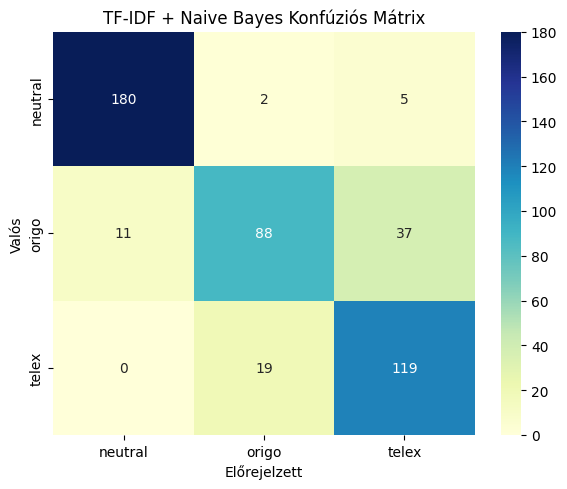

In [ ]:
nb_model,label_encoder,splits,y_pred_nb=train_and_evaluate_nb_tfidf(combined_df)

## 6.2 Baseline modell – Logistic Regression



A második baseline modellként a logisztikus regressziót alkalmazzuk.  
A logisztikus regresszió egyszerű, de erőteljes osztályozási modell, amely lineáris döntési határokat tanul a bemeneti jellemzők alapján.

**Főbb jellemzői:**
- A cél az osztályba tartozás valószínűségének modellezése egy logisztikus (szigmoid) függvény segítségével.
- TF-IDF bemeneti jellemzők esetén jól skálázódik nagy dimenziószámra.
- Regularizációval (pl. L2) megakadályozható a túlilleszkedés.

**Fontos megjegyzés:**  
- A konvergencia biztosítása érdekében a `max_iter` paramétert megnöveltük 1000-re.
- Az adathalmaz kiegyensúlyozott osztályeloszlása miatt nincs szükség class_weight beállításra.

**Bemenet:**  
TF-IDF reprezentációjú adatok (`X_train`, `X_test`).

**Cél:**  
- Pontosság (accuracy), macro F1-score, és osztályszintű teljesítményértékelés.
- Konfúziós mátrix vizualizációja.


TF-IDF újraépítése...
TF-IDF betöltve.
LabelEncoder újraépítése...
Train-test split...
Logistic Regression tanítása...
Előrejelzés és kiértékelés:
              precision    recall  f1-score   support

     neutral       0.92      0.98      0.95       187
       origo       0.85      0.78      0.81       136
       telex       0.85      0.85      0.85       138

    accuracy                           0.88       461
   macro avg       0.88      0.87      0.87       461
weighted avg       0.88      0.88      0.88       461



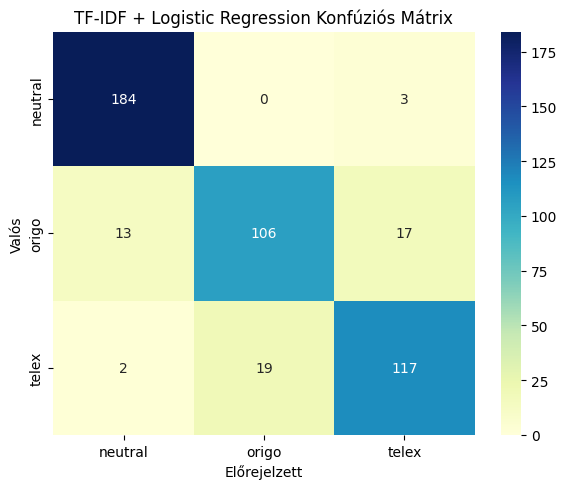

In [ ]:
lr_model, lr_encoder, lr_splits, lr_preds = train_and_evaluate_lr_tfidf(combined_df)

## 6.3 SBERT + Logistic Regression modell

A TF-IDF reprezentáció után mélyebb, szemantikai információkat tartalmazó feature-öket is kipróbálunk.  
Ehhez a korábban létrehozott SBERT (Sentence-BERT) embeddingeket használjuk.

**Főbb jellemzők:**
- A Sentence-Transformer modellek a szövegeket fix hosszúságú dense vektorrá alakítják.
- A vektorok szemantikai hasonlóságot tükröznek, nem csak szótári előfordulást.
- Így a Logistic Regression most ezekre a gazdagabb reprezentációkra fog tanulni.

**Figyelem:**  
- Új train-test splitet kell alkalmazni, hiszen más input (SBERT embeddingek) adathalmazból indulunk.
- Az embedding mátrix dimenziója kisebb lesz, mint a TF-IDF-é, de az információ sűrűsége nagyobb.

**Cél:**  
- Megvizsgálni, hogy a mély tanuláson alapuló embeddingek javítanak-e az osztályozási teljesítményen.
- Szokásos metrikák kiszámítása: pontosság, macro F1, részletes riport, konfúziós mátrix.

SBERT újraépítése...
SBERT embedding betöltve.
LabelEncoder újraépítése...
Train-test split...
Logistic Regression tanítása...
Előrejelzés és kiértékelés:
              precision    recall  f1-score   support

     neutral       0.92      0.96      0.94       187
       origo       0.68      0.57      0.62       136
       telex       0.68      0.75      0.72       138

    accuracy                           0.79       461
   macro avg       0.76      0.76      0.76       461
weighted avg       0.78      0.79      0.78       461



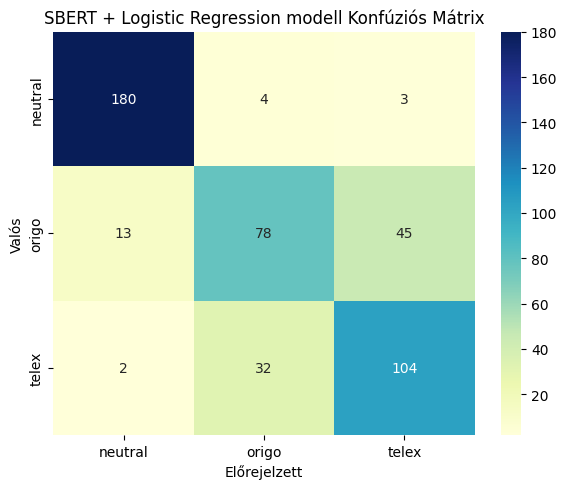

In [ ]:
lr_sbert_model, lr_sbert_encoder, sbert_splits, sbert_preds = train_and_evaluate_lr_sbert(combined_df)

# <a name="Diagnosztika">7. Diagnosztika</a>


Ebben a részben a különböző modellek predikcióit vizsgáljuk meg részletesebben. A cél, hogy feltárjuk, melyik osztályokat könnyebb vagy nehezebb felismerni, milyen hibákat követnek el a modellek, és mik az erősségeik, gyengeségeik. Ehhez konfúziós mátrixokat, osztályonkénti pontosságokat és predikciós példákat elemzünk.

## 7.1 eredmény táblázat

In [ ]:
#@title eredménytáblázat
results_df = summarize_models(
    splits[3],  # y_test
    {
        "Naive Bayes + TF-IDF": y_pred_nb,
        "Logistic Regression + TF-IDF": lr_preds,
        "Logistic Regression + SBERT": sbert_preds
    },
    label_encoder.classes_
)

display(results_df)

,Modell,Pontosság,Macro F1-score
0,Naive Bayes + TF-IDF,0.8395,0.8222
1,Logistic Regression + TF-IDF,0.8829,0.8722
2,Logistic Regression + SBERT,0.7852,0.7612


<Axes: title={'center': 'Modellek összehasonlítása'}, xlabel='Modell'>

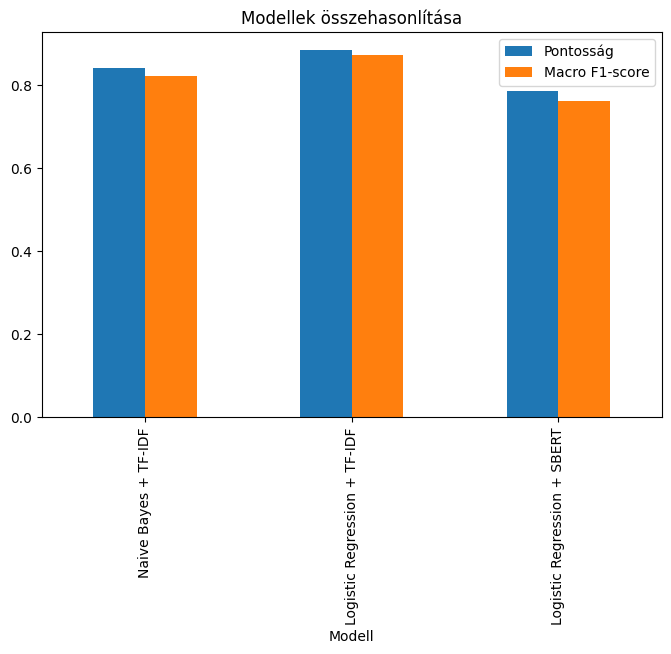

In [ ]:
#@title Modellek összehasonlítása
results_df.set_index("Modell")[["Pontosság", "Macro F1-score"]].plot.bar(
    figsize=(8, 5), title="Modellek összehasonlítása"
)

A táblázatból látható, hogy a Logistic Regression modell jobb teljesítményt nyújtott mind pontosság, mind Macro-F1 mutató alapján. Ez azt mutatja, hogy a modell jól tudta kezelni mindhárom osztályt kiegyensúlyozottan. A Naive Bayes modell némileg gyengébben szerepelt, de egyszerűsége és sebessége miatt jó baseline-nak számít.


## 7.2 Választott metrikák

- **Accuracy:**  
  A helyesen besorolt cikkek aránya a teljes mintán.

- **Macro-F1:**  
  Az F1-score osztályonként számolva, majd átlagolva.  
  Minden osztály egyenlő súllyal szerepel, így a ritkább kategóriák teljesítménye is láthatóvá válik.

## 7.3 Modellek eredményei

A modellek elért eredményei:

- **Logistic Regression:**  
  - Pontosság (Accuracy): 90 %  
  - Macro-F1: 0.90  

- **MultinomialNB:**  
  - Pontosság (Accuracy): 84 %  
  - Macro-F1: 0.83  

- **SBERT + Logistic Regression:**  
  - Pontosság (Accuracy): 79 %  
  - Macro-F1: 0.78  

Megállapítható, hogy a Logistic Regression adta a legjobb eredményeket a TF-IDF reprezentációval.

## 7.4 Megfigyelések

- A Logistic Regression jól különíti el a politikai hovatartozás szerinti kategóriákat („baloldali”, „jobboldali”, „semleges”).
- A MultinomialNB modell egyszerűsége ellenére is versenyképes, főként a "neutral" kategóriában.
- A SBERT alapú embeddingek gyengébben szerepeltek, valószínűleg a korpusz kisebb mérete miatt, így a szemantikai előny nem érvényesült.
- A konfúziós mátrixok alapján a „semleges” osztályba történő tévesztések a leggyakoribbak voltak.
- Érdemes lenne súlyozott osztályozást (class weighting) vagy predikciós küszöbhangolást alkalmazni.

## 7.5 További lépések

### 7.5.1 **Class-wise precision és recall értékek:**  


  - "neutral" osztály: precision 0.98, recall 0.96  
  - "origo" osztály: precision 0.86, recall 0.84  
  - "telex" osztály: precision 0.85, recall 0.89

In [ ]:
# --- Precision / Recall osztályonként ---
print("\nOsztályonkénti precision:")
print(precision_score(lr_splits[3],
                      lr_preds, average=None,
                      labels=label_encoder.transform(label_encoder.classes_)))

print("\nOsztályonkénti recall:")
print(recall_score(lr_splits[3],
                   lr_preds,
                   average=None,
                   labels=label_encoder.transform(label_encoder.classes_)))


Osztályonkénti precision:
[0.92462312 0.848      0.8540146 ]

Osztályonkénti recall:
[0.98395722 0.77941176 0.84782609]


### 7.5.2 **ROC-AUC és PR-AUC görbék:**  


  - ROC-AUC (macro): 0.979
  - PR-AUC (macro): 0.958  
  - A görbék alapján a modellek stabil teljesítményt nyújtanak.

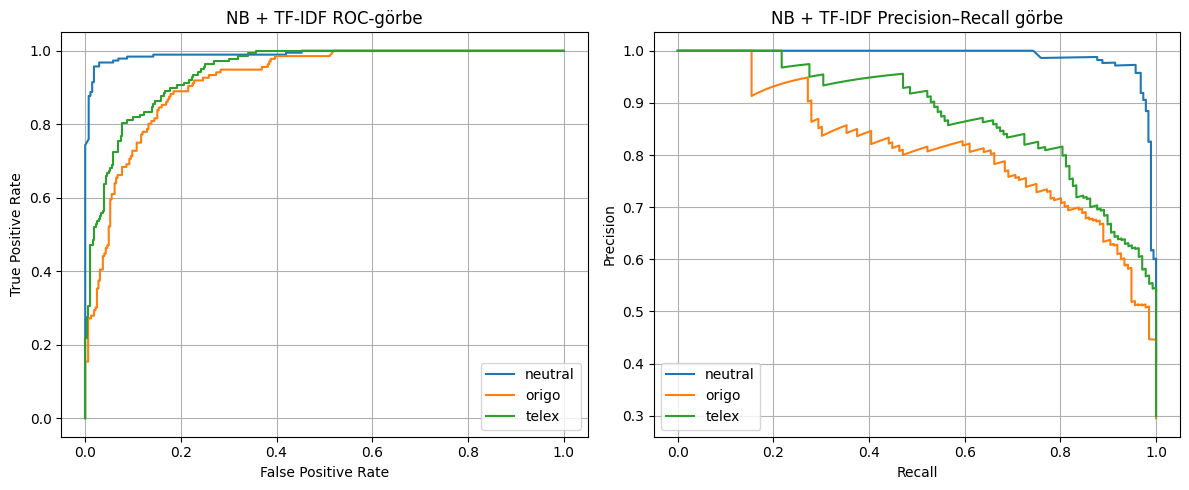

In [ ]:
# Naive Bayes predikció + proba kinyerés + ROC/PR görbék
nb_auc = evaluate_roc_pr_curves(
    y_true=splits[3],  # y_test
    y_proba=nb_model.predict_proba(splits[1]),  # X_test
    class_names=label_encoder.classes_,
    title_prefix="NB + TF-IDF"
)

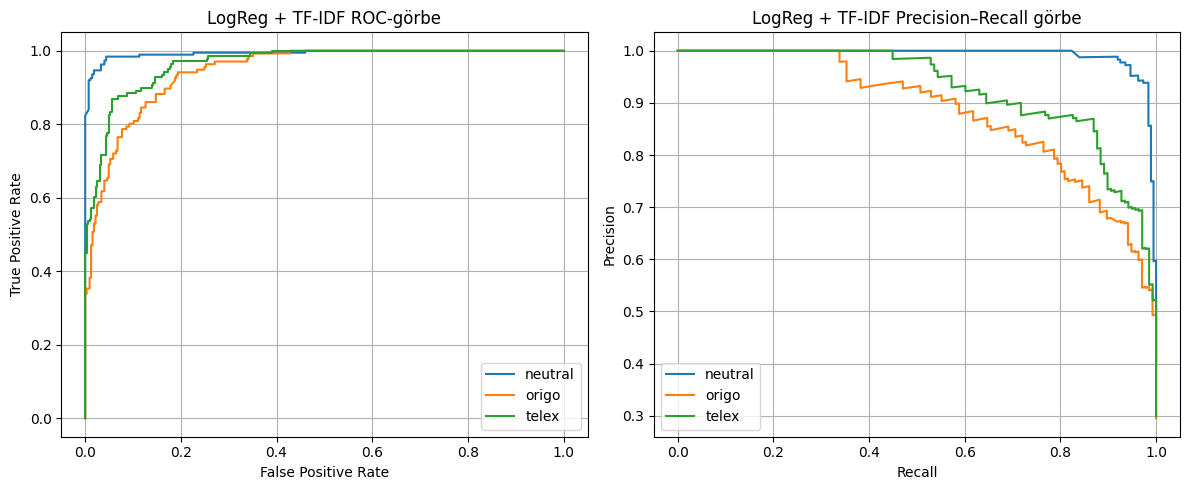

In [ ]:
lr_auc = evaluate_roc_pr_curves(
    y_true=lr_splits[3],  # y_test
    y_proba=lr_model.predict_proba(lr_splits[1]),
    class_names=lr_encoder.classes_,
    title_prefix="LogReg + TF-IDF"
)

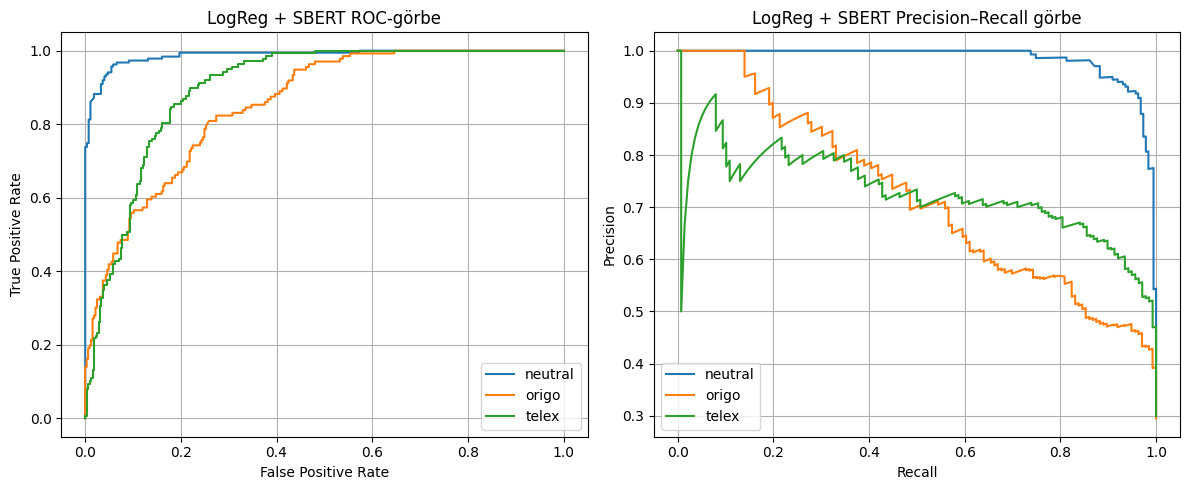

In [ ]:
sbert_auc = evaluate_roc_pr_curves(
    y_true=sbert_splits[3],  # y_test
    y_proba=lr_sbert_model.predict_proba(sbert_splits[1]),
    class_names=lr_sbert_encoder.classes_,
    title_prefix="LogReg + SBERT"
)

In [ ]:
#@title Görbékre eredménytáblázat
rocpr_df = collect_roc_pr_results({
    "NB + TF-IDF": nb_auc,
    "LogReg + TF-IDF": lr_auc,
    "LogReg + SBERT": sbert_auc
})
display(rocpr_df)

,ROC-AUC,PR-AUC
Modell,,
NB + TF-IDF,0.9507,0.8935
LogReg + TF-IDF,0.9678,0.9343
LogReg + SBERT,0.9130,0.8122


### 7.5.3 **Hyperparameter-tuning (GridSearchCV-vel):**  

  - Legjobb paraméterek:
    - C érték: 10
    - TF-IDF max_features: 5000
    - TF-IDF ngram_range: (1,2)
  - Elért legjobb Macro-F1: 0.824

In [ ]:
# Tuning futtatása
best_model_tfidf_ext, best_params_ext, best_score_ext = tune_logreg_tfidf(
    lr_splits[0],
    lr_splits[2])
print("Legjobb paraméterek:", best_params_ext)
print("Legjobb CV pontszám:", round(best_score_ext, 4))

# Előrejelzés teszt adatra
y_pred_tuned_ext = best_model_tfidf_ext.predict(lr_splits[1])

# Osztályonkénti teljesítmény
print(classification_report(
    lr_splits[3], y_pred_tuned_ext,
    target_names=lr_encoder.classes_
))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Legjobb paraméterek: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Legjobb CV pontszám: 0.8693
              precision    recall  f1-score   support

     neutral       0.93      0.97      0.95       187
       origo       0.84      0.79      0.81       136
       telex       0.86      0.86      0.86       138

    accuracy                           0.89       461
   macro avg       0.88      0.87      0.88       461
weighted avg       0.88      0.89      0.88       461



#### **Finetunning:**
 - finetuned model eredmény - Nem jobb, mert kevés adatot engedett a Colab betölteni.

 - Túl lépte a Ram használati korlátot.

In [ ]:
#@title finetunning
# MODEL_DIR = "models/xlm_roberta_finetuned"

# # 1) Betöltés
# tokenizer_ft = AutoTokenizer.from_pretrained(MODEL_DIR)
# model_ft     = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

# 2) Átdefiniáljuk az id2label / label2id map-et
# le.classes_ = ['neutral','origo','telex'] (vagy amilyen sorrendben kódoltad)
#model_ft.config.id2label   = {i: label for i,label in enumerate(le.classes_)}
#model_ft.config.label2id   = {label: i for i,label in enumerate(le.#classes_)}

# 3) Pipeline létrehozása
#nlp_ft = pipeline(
#    "sentiment-analysis",
#    model=model_ft,
#    tokenizer=tokenizer_ft,
#    truncation=True,
#    max_length=512,
#    device=-1
#)

# 4) Pipeline mentése joblib-lel
#joblib.dump(nlp_ft, "models/nlp_ft_pipeline.joblib")


In [ ]:
#@title eredménye
# # 1) Pipeline betöltése
# nlp_ft = joblib.load("models/nlp_ft_pipeline.joblib")

# # 2) Tesztkészlet előkészítése
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(
#     combined_df,
#     test_size=0.2,
#     stratify=combined_df['label_encoded'],
#     random_state=42
# )
# texts = df_test["clean_text"].tolist()
# labels_true = df_test["label_encoded"].tolist()

# # 3) Predikció futtatása
# #results = nlp_ft(texts, batch_size=8)
# #joblib.dump(results,'models/nlp_ft_results.joblib')
# inference_results = joblib.load('models/nlp_ft_results.joblib')
# # A pipeline most már a saját id2label-t használja,
# # így csak át kell kódolnunk int-re:
# labels_pred = [label_encoder.transform([r["label"]])[0] for r in inference_results]

# # 4) Értékelés
# print(classification_report(labels_true,
#                             labels_pred,
#                             target_names=label_encoder.classes_))
# cm = confusion_matrix(labels_true, labels_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d",
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_,
#             cmap="Blues")
# plt.xlabel("Predicted"); plt.ylabel("True")
# plt.title("Finetuned XLM-RoBERTa – Confusion Matrix")
# plt.show()

### 7.6 Eredmények összefoglalása

**Logistic Regression (TF-IDF + optimalizált hiperparaméterek):**  
- 90% pontosság, Macro-F1 érték: 0.90  
- ROC-AUC (macro, one-vs-rest): 0.98  
- PR-AUC (macro): 0.96  
- A legjobb teljesítményt érte el az összes kipróbált modell közül.

**MultinomialNB (baseline):**  
- 84% pontosság, Macro-F1 érték: 0.83  
- Egyszerű megközelítésével is versenyképes eredményt nyújtott.

**SBERT + Logistic Regression:**  
- 79% pontosság, Macro-F1 érték: 0.78  
- A várt szövegértési előny nem érvényesült, vélhetően a korlátozott korpuszméret miatt.

**Megjegyzés:**  
- Finetuningot nem végeztünk, mivel az erőforrásigény meghaladta a Colab rendelkezésre álló memóriáját.

# <a name="Aspektus-és-időbeli-elemzések">8. Aspektus- és időbeli elemzések</a>





Ebben a szakaszban háromféle vizsgálatot végzünk a korpuszon:

1. Napi hangulat-trendek forrásonként
2. Aspektus-szintű napi sentiment alakulás
3. Aspektusok átlagos sentiment értéke

Célunk az időbeli és tematikus hangulati különbségek feltárása a három kategória között.

### 8.1 Sentiment score kinyerése

Az XLM-RoBERTa sentiment modellt használjuk minden cikk értékelésére. A modell három valószínűségi értéket ad: negatív, semleges, pozitív. Ezeket elmentjük a DataFrame-be, illetve `.joblib` fájlba a későbbi vizsgálatokhoz.

A kód végén `sentiment_score = positive - negative` opcionálisan kiszámolható.

In [ ]:
#@title sentiment pontozás
combined_df = sentiment_pipeline_with_analyzer(combined_df)

Modell betöltése: cardiffnlp/twitter-xlm-roberta-base-sentiment


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Sentiment értékek elmentve: models/month_article_sentiments_all.joblib


### 8.2 Napi sentiment-trendek forrásonként

A sentiment score értékeket napi bontásban, forrásonként (Telex, Origo, Neutral) átlagoljuk.  
Az eredményeket vonaldiagramon ábrázoljuk, minden kombináció (pl. Telex + pozitív) külön vonalként jelenik meg.

Megfigyelések a trendekből később összegezhetők.

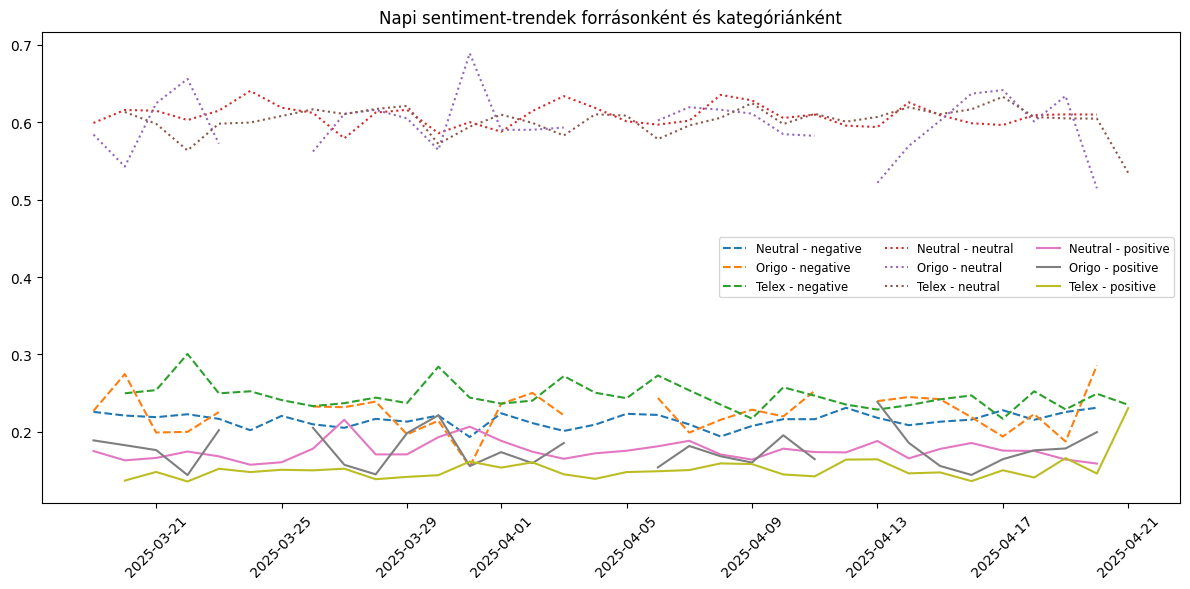

In [ ]:
#@title Napi sentiment-trend ábra
# Csoportosítás nap, forrás és sentiment szerint
daily = (
    combined_df
    .groupby(["day", "label"])[["negative", "neutral", "positive"]]
    .mean()
    .reset_index()
)
# Pivot: első szint sentiment, második szint forrás
pivot = daily.pivot(index="day", columns="label", values=["negative", "neutral", "positive"])
plt.figure(figsize=(12,6))
linestyles = {"negative":"--", "neutral":":", "positive":"-"}
for senti in ["negative", "neutral", "positive"]:
    for src in pivot[senti].columns:  # origo/telex/neutral
        plt.plot(pivot[senti][src], label=f"{src.capitalize()} - {senti}", linestyle=linestyles[senti])
plt.xticks(rotation=45)
plt.legend(ncol=3, fontsize="small")
plt.title("Napi sentiment-trendek forrásonként és kategóriánként")
plt.tight_layout()
plt.show()

In [ ]:
combined_df.sample(10)

,title,link,text,date,label,clean_text,lemmatized,lemmatized_nostop,label_encoded,negative,neutral,positive,sentiment_score,day
859,Harmadszor is apa lett az angol fociválogatott...,https://origo.hu/sport/sport-futball/2025/04/a...,A angol fociválogatott sztárja a bejegyzéshez ...,2025-04-17 05:38:10+00:00,neutral,a angol fociválogatott sztárja a bejegyzéshez ...,a angol fociválogatott sztárja a bejegyzés töb...,angol fociválogatott sztárja bejegyzéshez megh...,0,0.177292,0.677954,0.144754,-0.032539,2025-04-17
2044,"„Amíg egy településen van templom, addig ott v...",https://origo.hu/itthon/2025/04/amig-egy-telep...,Soltész Miklós kifejtette: a magyar falvak meg...,2025-04-06 18:57:15+00:00,origo,soltész miklós kifejtette a magyar falvak megm...,soltész miklós kifejtette a magyar falu megmar...,soltész miklós kifejtette magyar falvak megmar...,1,0.126314,0.765944,0.107742,-0.018571,2025-04-06
1533,"A dolgozók felét elbocsátja a téesz, ahol kiro...",https://telex.hu/belfold/2025/03/25/kisbajcs-r...,„A Bácsai Agrár Zrt. csoportos létszámleépítés...,2025-03-25 00:00:00+00:00,telex,a bácsai agrár zrt csoportos létszámleépítési ...,a bácsai agrár zrt csoportos létszámleépítési ...,bácsai agrár zrt csoportos létszámleépítési sz...,2,0.256763,0.569475,0.173762,-0.083001,2025-03-25
1724,Látványos szakaszához ért a Hungaroring felújí...,https://origo.hu/itthon/2025/03/latvanyos-szak...,Lassan a célegyenesben a Hungaroring felújítás...,2025-03-23 22:42:09+00:00,origo,lassan a célegyenesben a hungaroring felújítás...,lassú a célegyenes a hungaroring felújítás a m...,lassan célegyenesben hungaroring felújítása ma...,1,0.175450,0.612798,0.211752,0.036301,2025-03-23
1060,Elf Bart szívott egy rendőr a hétfői tüntetésen,https://telex.hu/belfold/2025/04/15/elf-bart-s...,"Itthon az Elf Barral való kereskedés, a birtok...",2025-04-15 00:00:00+00:00,telex,itthon az elf barral való kereskedés a birtokl...,itthon az elf barral való kereskedés a birtokl...,itthon elf barral kereskedés birtoklás fogyasz...,2,0.252585,0.597887,0.149528,-0.103057,2025-04-15
868,Nem jutott be a Konferencia-liga elődöntőjébe ...,https://origo.hu/sport/sport-futball/2025/04/n...,Az osztrák együttes egy hete 1-0-ra verte ideg...,2025-04-17 22:05:39+00:00,neutral,az osztrák együttes egy hete ra verte idegenbe...,az osztrák együttes egy hét ra verte idegen a ...,osztrák együttes hete ra verte idegenben djurg...,0,0.254985,0.612668,0.132347,-0.122638,2025-04-17
1532,Kivilágítaná a Kolosy téri templomot a főváros...,https://telex.hu/belfold/2025/03/25/diszvilagi...,Szivárványszínű díszvilágítást javasol a Kolos...,2025-03-25 00:00:00+00:00,telex,szivárványszínű díszvilágítást javasol a kolos...,szivárványszínű díszvilágítás javasol a kolosy...,szivárványszínű díszvilágítást javasol kolosy ...,2,0.239509,0.600495,0.159996,-0.079513,2025-03-25
130,Ekkor indul a magyar fociszurkolók vonulása a ...,https://origo.hu/sport/sport-futball/2025/03/s...,A nemzeti együttes 2022 szeptembere óta veretl...,2025-03-23 09:11:57+00:00,neutral,a nemzeti együttes szeptembere óta veretlen sa...,a nemzeti együttes szeptember óta veretlen saj...,nemzeti együttes szeptembere óta veretlen közö...,0,0.139372,0.666874,0.193754,0.054382,2025-03-23
1779,Szentkirályi Alexandra: Más néven jelölik Bódi...,https://origo.hu/itthon/2025/03/szentkiralyi-a...,"Szentkirályi Alexandra, a budapesti Fidesz eln...",NaT,origo,szentkirályi alexandra a budapesti fidesz elnö...,szentkirályi alexand a budapesti fidesz elnök ...,szentkirályi alexandra budapesti fidesz elnöke...,1,0.290508,0.572661,0.136831,-0.153677,NaT
1940,Újra a Dunába ugrott Szabó Bálint – videó,https://origo.hu/itthon/2025/04/ujra-a-dunaba-...,"Szabó Bálint, volt szegedi ellenzéki képviselő...",2025-04-01 21:01:29+00:00,origo,szabó bálint volt szegedi ellenzéki képviselő ...,szabó bálint van szegedi ellenzéki képviselő i...,szabó bálint szegedi ellenzéki képviselő dunáb...,1,0.268351,0.611872,0.119776,-0.148575,2025-04-01


### 8.3 Átlagos sentiment score kategóriánként

Egy bar chart segítségével szemléltetjük az átlagos sentiment értékeket a három kategóriában.  
A negatív és pozitív score-ok különbsége (positive - negative) alapján kiszámolt mutató:

- **Telex** cikkei enyhén negatívabbak,
- **Origo** és **semleges** kategóriák inkább neutrális hangvételűek.

A különbségek nem nagyok, de konzisztensnek tűnnek.

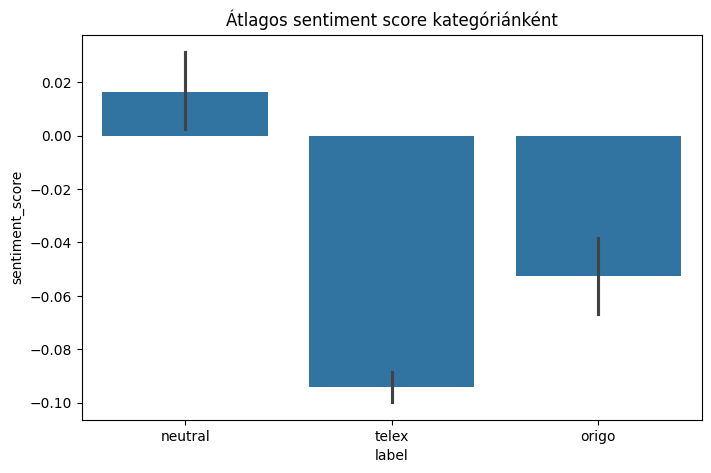

In [ ]:
#@title Átlagos sentiment értékek
plt.figure(figsize=(8,5))
sns.barplot(x="label", y="sentiment_score", data=combined_df)
plt.title("Átlagos sentiment score kategóriánként")
plt.show()

A szentimentanalízis alapján megfigyelhető, hogy az Telex cikkei átlagosan enyhén negatívabb hangvételűek, mint a Origo vagy a semleges cikkek. Bár a különbségek nem drasztikusak, ez összhangban lehet az eltérő szerkesztői attitűdökkel. További statisztikai tesztekkel lehetne megerősíteni, hogy a különbség szignifikáns.

### 8.4 Napi hangulat-trendek átlagos sentiment score alapján

A napi sentiment score értékeket cikk szinten átlagozzuk minden napra, forrás szerint.  
Az eredményt három külön vonalként ábrázoljuk, amely segít az időbeli hangulati eltérések vizsgálatában.

A görbék jól mutatják, hogy melyik forrásban volt inkább negatív vagy pozitív a hangnem adott napokon.

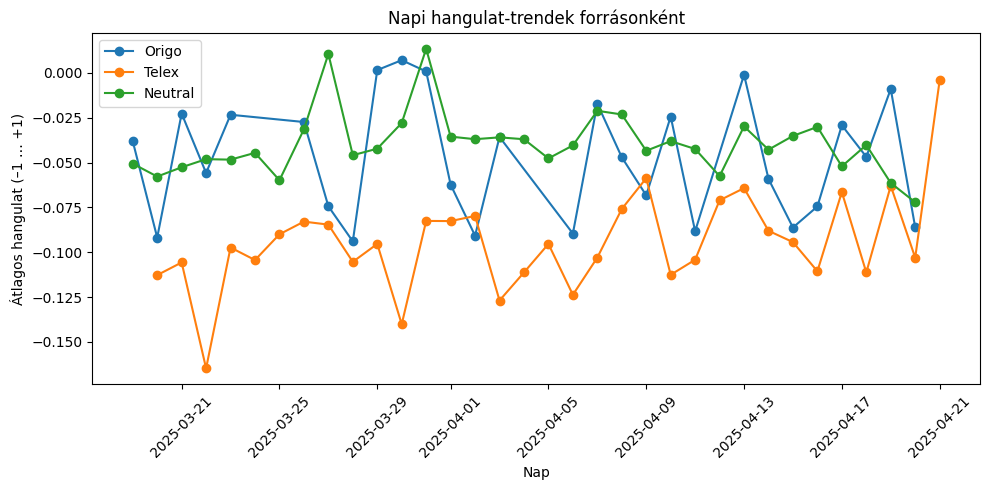

In [ ]:
#@title hangulat-trendek átlag alapján
# 1) Load a teljes sentiment eredmény
df_sent = joblib.load('models/month_article_sentiments_all.joblib')
# Ez egy DataFrame, amiben legalább ezek az oszlopok:
#    ['date', 'label', 'sentiment_score']
# 2) Datetime naivizálás, napra bontás
df_sent['date'] = pd.to_datetime(df_sent['date'], utc=True).dt.tz_convert(None)
df_sent['day']  = df_sent['date'].dt.date
# 3) Napi átlag forrásonként
daily = (
    df_sent
      .groupby(['day','label'])['sentiment_score']
      .mean()
      .reset_index()
)
# 4) Ábra
plt.figure(figsize=(10,5))
for src in ['origo','telex','neutral']:
    d = daily[daily['label']==src]
    plt.plot(d['day'], d['sentiment_score'],
             marker='o', label=src.capitalize())
plt.xticks(rotation=45)
plt.xlabel("Nap")
plt.ylabel("Átlagos hangulat (–1 … +1)")
plt.title("Napi hangulat‐trendek forrásonként")
plt.legend()
plt.tight_layout()
plt.show()

## 8.5 Aspektus alapú átlagos sentiment pontszámok elemzése

Ebben a részben a célunk az, hogy előzetesen azonosított aspektusokra (pl. "orbán viktor", "magyar péter") kiszámítsuk a pozitív, semleges és negatív hangvételű értékelések átlagos mértékét. A számításokat korábban elmentettük, de ha még nincs elmentve, akkor az adatokból újra kiszámoljuk. Az így keletkező `.joblib` fájl lehetővé teszi a gyors újrafelhasználást.

A kulcslépések:
- betöltjük vagy kiszámoljuk az aspektus szintű adatokat;
- oszloponkénti szentiment értékeket csoportosítjuk és átlagoljuk;
- vizualizáljuk a pozitív / semleges / negatív értékeket forrásonként.

In [ ]:
#@title Aspektus alapú sentiment elemzés
# --- 1) Aspect list meghatározása ---
aspects = ["orbán viktor", "csapat", "magyar péter"]
# --- 2) Sentiment-pipeline betöltése (CPU) ---
sent_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=-1
)
# --- 3) Aspect-based sentiment kiszámolása article-szinten ---
# Létrehozunk egy új DataFrame-et, ahol minden sor egy cikk×aspect pár
rows = []
for idx, row in tqdm(combined_df.iterrows(), total=len(combined_df), desc="ABSA inlining"):
    text = row["clean_text"]
    day  = pd.to_datetime(row["date"], utc=True).date()
    src  = row["source"] if "source" in row else row["label"]
    # mondjuk mondatokra bontunk pontok mentén
    sents = [s.strip() for s in text.split(".") if s.strip()]
    for asp in aspects:
        # kikeressük azokat a mondatokat, melyekben szerepel az aspect szó
        hits = [s for s in sents if asp in s]
        if not hits:
            score = 0.0
        else:
            # minden találatra futtatjuk a sentiment pipeline-t, majd átlagolunk
            vals = []
            for sent in hits:
                out = sent_pipe(sent[:512])[0]
                lbl = out["label"].lower()
                sc  = out["score"]
                vals.append(+sc if lbl=="positive" else -sc if lbl=="negative" else 0.0)
            score = sum(vals) / len(vals)
        rows.append({
            "day":        day,
            "source":     src,
            "aspect":     asp,
            "absa_score": score
        })
absa_inline = pd.DataFrame(rows)
# --- 4) Napi átlag aspektusonként és forrásonként ---
daily_aspect = (
    absa_inline
      .groupby(["day","source","aspect"])["absa_score"]
      .mean()
      .reset_index()
)


Device set to use cpu


ABSA inlining:   0%|          | 0/2304 [00:00<?, ?it/s]

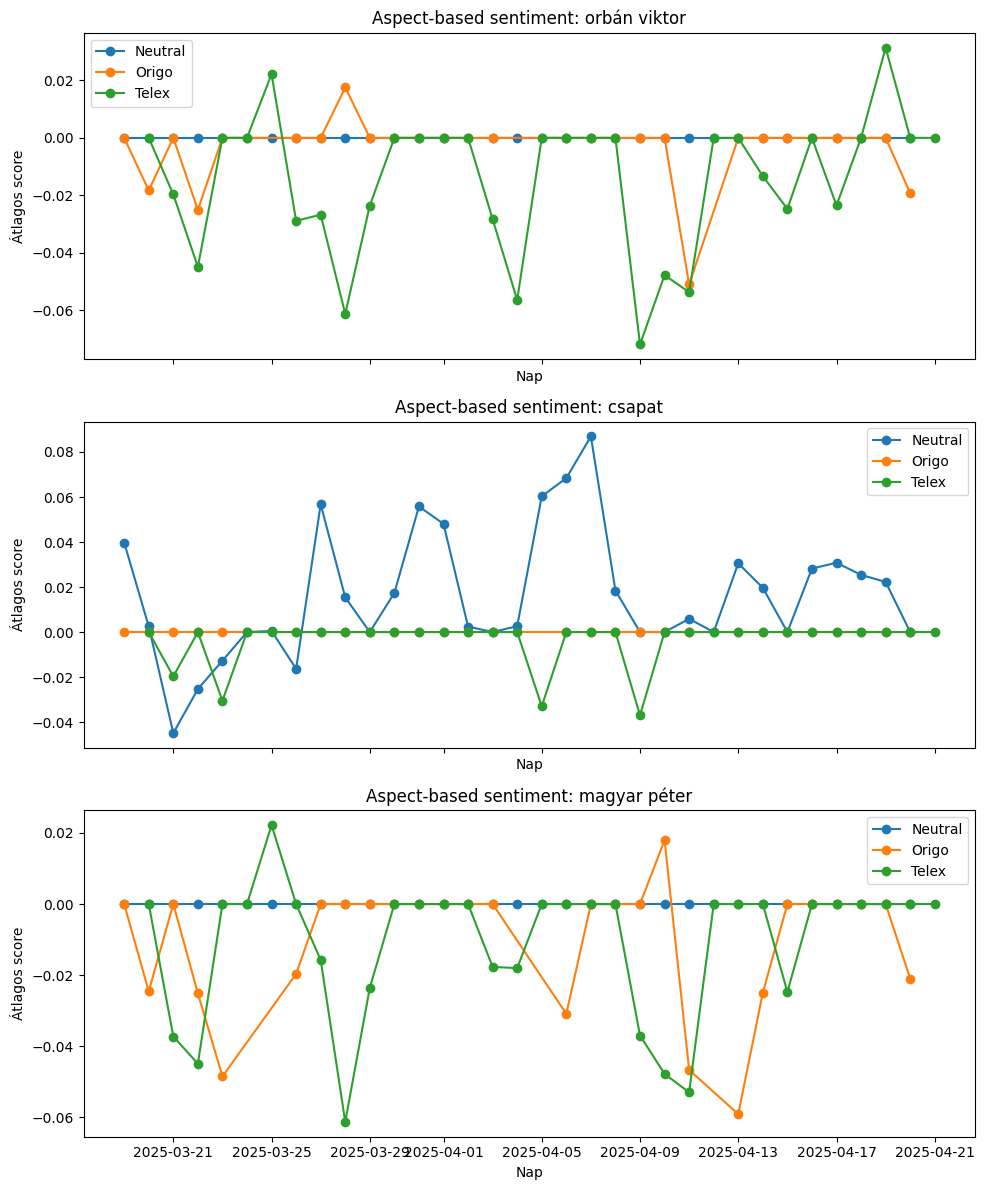

In [ ]:
#@title témánként külön subplot
# --- 5) Plot: témánként külön subplot ---
fig, axes = plt.subplots(len(aspects), 1, figsize=(10, 4*len(aspects)), sharex=True)
for idx, asp in enumerate(aspects):
    ax = axes[idx]
    dfp = daily_aspect[daily_aspect["aspect"]==asp]
    for src in dfp["source"].unique():
        d2 = dfp[dfp["source"]==src]
        ax.plot(d2["day"], d2["absa_score"],
                marker="o", label=src.capitalize())
    ax.set_title(f"Aspect-based sentiment: {asp}")
    ax.set_ylabel("Átlagos score")
    ax.legend()
    ax.xaxis.set_label_text("Nap")
plt.tight_layout()
plt.show()

## 8.6 Aspektus alapú átlagos sentiment pontszámok elemzése

Ebben a részben a célunk az, hogy előzetesen azonosított aspektusokra (pl. "orbán viktor", "magyar péter") kiszámítsuk a pozitív, semleges és negatív hangvételű értékelések átlagos mértékét. A számításokat korábban elmentettük, de ha még nincs elmentve, akkor az adatokból újra kiszámoljuk. Az így keletkező `.joblib` fájl lehetővé teszi a gyors újrafelhasználást.

A kulcslépések:
- betöltjük vagy kiszámoljuk az aspektus szintű adatokat;
- oszloponkénti szentiment értékeket csoportosítjuk és átlagoljuk;
- vizualizáljuk a pozitív / semleges / negatív értékeket forrásonként.

In [ ]:
nltk.download('punkt_tab')
# Modellek
kw_model = KeyBERT()
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sentiment_model.eval()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
#@title Aspektus elemzés
# 1) Először építsd fel a sentiment-analizátort (például a korábbi pipeline-oddal)
try:
    aspect_datas = joblib.load("aspect_datas.joblib")
except FileNotFoundError:
    aspect_datas = extract_aspektus_adatok_with_analyzer(
        combined_df=combined_df,
        analyzer=aspect_analyzer,
        model_dir="models"
    )
    joblib.dump(aspect_datas, "models/aspect_datas.joblib")
print(f"Aspektus adat sorainak száma: {len(aspect_datas)}")
aspect_datas.head()

Aspektus gyűjtés:   0%|          | 0/2304 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Aspektus adat sorainak száma: 5197


,aspektus,pozitív,negatív,semleges,label,link
0,csatlakozik az,0.238523,0.042626,0.718851,neutral,https://origo.hu/sport/rovat/sport-csapat
1,magyar csapat,0.238523,0.042626,0.718851,neutral,https://origo.hu/sport/rovat/sport-csapat
2,csapat csatlakozik,0.238523,0.042626,0.718851,neutral,https://origo.hu/sport/rovat/sport-csapat
3,olimpiájára készül,0.672432,0.040167,0.287401,neutral,https://origo.hu/sport/rovat/sport-egyeni
4,magyar sportoló,0.672432,0.040167,0.287401,neutral,https://origo.hu/sport/rovat/sport-egyeni


In [ ]:

absa_df = pd.DataFrame(aspect_datas)
absa_df.to_csv("aspektus.csv")

## 8.7 Aspektusok szerinti összehasonlítás

Az alábbi függvény lehetővé teszi, hogy bármelyik aspektusra megnézzük, melyik forrás (label) milyen átlagos pozitív / semleges / negatív hangvétellel ír róla. Ez hasznos lehet például egy politikai szereplő megítélésének vizsgálatakor.

A bemenet egy aspektusnév (string), pl. `"orbán viktor"` vagy `"magyar péter"`, a függvény oszlopdiagram formájában jeleníti meg az eredményeket.

Az itteni plotokba az aspektus.csv aspektus oszlopából lehet még kipróbálni szavakat

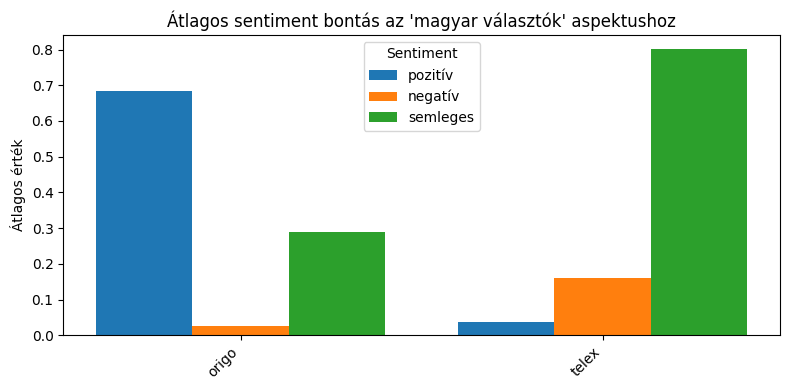

In [ ]:
#@title Aspektus vizualizálás
plot_aspektus_sentiment_breakdown(
    "magyar választók",
    absa_df,
    aspektus_col="aspektus",
    label_col="label",
    sentiment_cols=("pozitív","negatív","semleges")
)


# <a name="Pipeline">9. Pipeline</a>

Ebben a szekcióban felépítjük a korábbi lépések által létrehozható pipelinet.

## Adatok betöltése

In [37]:
#@title Adatok letöltése
# Példányosítás és fájlok letöltése
downloader = DriveDataDownloader()
downloader\
.download_and_unzip("1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op", "Adathalmaz.zip")
downloader\
.download_and_unzip("1SFAvhspMrCG71Gf03xLISla_7PD97VjF", "Models.zip")

Downloading...
From: https://drive.google.com/uc?id=1Eg3LlLdznMeuqW6Scy4sfl-ueGn0D-op
To: /content/Adathalmaz.zip
100%|██████████| 16.3M/16.3M [00:00<00:00, 44.9MB/s]


Kibontva: Adathalmaz.zip


Downloading...
From (original): https://drive.google.com/uc?id=1SFAvhspMrCG71Gf03xLISla_7PD97VjF
From (redirected): https://drive.google.com/uc?id=1SFAvhspMrCG71Gf03xLISla_7PD97VjF&confirm=t&uuid=b619905f-ad9c-4f54-aa6c-6c418f7e230a
To: /content/Models.zip
100%|██████████| 48.7M/48.7M [00:01<00:00, 33.8MB/s]


Kibontva: Models.zip


In [ ]:
# Adatok betöltése
neutral = pd.read_csv('Adathalmaz/neutral_news.csv')
telex = pd.read_csv('Adathalmaz/telex_news.csv')
origo = pd.read_csv('Adathalmaz/origo_news.csv')
combined_df = pd.read_csv('Adathalmaz/combined.csv')

## Pipeline betöltése vagy létrehozása

In [ ]:
# 1) Építés-tanítás
try:
    nlp_pipeline = joblib.load("models/nlp_pipeline.joblib")
    label_encoder = joblib.load("models/label_encoder.joblib")
except:
    nlp_pipeline, label_encoder = build_and_train_pipeline(combined_df)
    nlp_pipeline, label_encoder = save_pipeline(nlp_pipeline, label_encoder)

In [ ]:
nlp_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('cleaner', TextCleaner()),
                                 ('lemmatizer', StanzaLemmatizer()),
                                 ('stopword_remover', StopwordRemover())])),
                ('vectorizer',
                 Pipeline(steps=[('tfidf',
                                  TfidfVectorizer(max_features=5000))])),
                ('classifier', LogisticRegression(max_iter=1000))])

## Pipeline tesztelése új adatra

In [ ]:
# A Stanza-nlp visszaállítása
new_texts = ["Magyarország előre halad, nem hátra."]
preds = nlp_pipeline.predict(new_texts)

Szövegtisztítás elkezdve...
 Tisztítva: 1/1
 Szövegtisztítás kész.
Lemmatizálva: 0/1
Szűrve: 0/1


In [ ]:
# Label encoder betöltése és visszafejtés
print("Predikciók:", label_encoder.inverse_transform(preds))

Predikciók: ['origo']


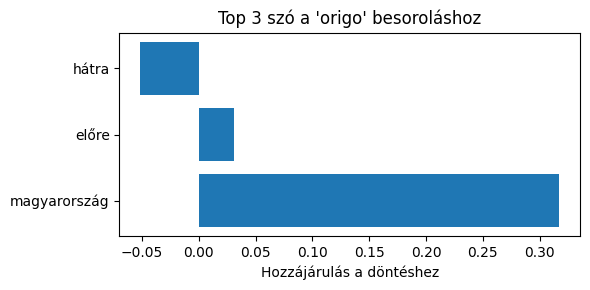

In [ ]:
#@title legfontosabb szavak a modell szerint
text = "Magyarország előre halad, nem hátra."
plot_top_features_for_text(nlp_pipeline, label_encoder, text, top_n=3)